# Load Modules
- This code is created by Luke Chang : https://github.com/cosanlab/vmPFC_dynamics/blob/master/Notebooks/2_VMPFC_ISC_Analyses.ipynb

In [7]:
%matplotlib inline

import warnings
from copy import deepcopy
import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltools.stats import (threshold, 
                           align,
                           fdr, 
                           isc,
                           _calc_pvalue)
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import _calc_pvalue, align_states, circle_shift

from fnl_tools.utils import get_rect_coord,rec_to_time
from fnl_tools.plotting import plot_recurrence
from fnl_tools.stats import compute_ISC_all_roi, create_average_concordance

from nilearn.plotting import plot_glass_brain

from sklearn.utils import check_random_state
from sklearn.metrics import pairwise_distances

from scipy.stats import pearsonr

warnings.filterwarnings('ignore')

base_dir = '/mnt/c/Users/since/Desktop/KdramaSpring/'
data_dir = '/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/'
denoised_dir = os.path.join(base_dir, 'analysis', 'denoised')
Zdenoised_dir = os.path.join(base_dir, 'analysis', 'denoised_zscore')
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
#mask = Brain_Data(os.path.join(base_dir,'analysis', 'Masks', 'k50_2mm.nii.gz'))

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


# Load Parcellation Mask

In [7]:
from nltools.mask import expand_mask
mask_x = expand_mask(mask)
# We also saved the denoised viewing data as an hdf5 file to speed up loading times when using nltools.
subjects = ['01', '03', '04', '05', '06', '08']

for s in subjects:
    file_list = glob.glob(os.path.join(Zdenoised_dir, f'sub-{s}_*.hdf5'))
    for f in file_list:
   
        data = Brain_Data(f)
        print(sub)
        #data.write(f"{f.split('.nii.gz')[0]}.hdf5")
        #print('finish'+f"{f.split('.nii.gz')[0]}.hdf5")

sub-01
sub-01
sub-01
sub-01
sub-01


KeyboardInterrupt: 

In [9]:
mask_x = expand_mask(mask)
mask_x.shape

<bound method Brain_Data.shape of nltools.data.brain_data.Brain_Data(data=(50, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)>

In [10]:
from nltools.mask import expand_mask
mask_x = expand_mask(mask)

# Write out ROIs analysis
subjects = ['01', '02', '03', '04', '05', '06', '08']
for s in tqdm(subjects):
    file_list = glob.glob(os.path.join(Zdenoised_dir, f'sub-{s}_denoise_task-encoding_*.hdf5')) # task-encoding 에 대해서만 분석 
    #print(len(file_list))
    for f in file_list:
        sub = os.path.basename(f).split('_')[0]
        run = os.path.basename(f).split('_')[3]
        print(run)
        data = Brain_Data(f)
        for i,m in enumerate(mask_x):
            roi = data.apply_mask(m)
            pd.DataFrame(roi.data).to_csv(os.path.join(Zdenoised_dir, 'Denoised_ROI', f'{sub}_task-encoding_{run}_denoised_roi{i}.csv' ), index=False)

  0%|                                                                                             | 0/7 [00:00<?, ?it/s]

run-1
run-2


 14%|████████████▏                                                                        | 1/7 [01:33<09:20, 93.35s/it]

run-1
run-2


 29%|████████████████████████▎                                                            | 2/7 [03:14<08:08, 97.66s/it]

run-1
run-2


 43%|████████████████████████████████████▍                                                | 3/7 [04:51<06:29, 97.38s/it]

run-1
run-2


 57%|████████████████████████████████████████████████▌                                    | 4/7 [06:25<04:48, 96.25s/it]

run-1
run-2


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [08:02<03:12, 96.41s/it]

run-1
run-2


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [09:39<01:36, 96.57s/it]

run-1
run-2
run-3
run-4


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [12:16<00:00, 105.18s/it]


In [43]:
os.path.basename(f).split('_')[2]

'task-encoding'

# Calculate Spatial ISC 

- Temporal recurrence of spatial patterns

We created a spatial recurrence matrix by taking the pairwise Pearson correlation of the vectorized HPC activity for each TR collected during each story. This results in a number-of-TRs by number-of-TRs matrix reflecting the degree to which the spatial activity patterns in the HPC are correlated at each pair of TRs. Sequential TRs where the spatial configuration of the HPC persists create a block diagonal structure. Recurring activity patterns at distant time points are reflected in the off-diagonal similarity.

## 개별 이야기에 대한 spatial ISC 

### 전체 참가자 

In [564]:
onset = [11, 131, 251, 371, 489] 
offset = [126, 246, 366, 486, 604] 
subjects = ['02', '03', '04']
#subjects = ['05', '06']
stroy_duration = 115 #2 mins 45 secs + 9 secs => 116 TRs (110 + 5) 
#all_roi_isc = {} 
#all_time_dat = {}
#all_brain4story= {}
for sub in tqdm(subjects):            
    roi_isc = {}
    time_dat = {}
    story = {} 
    for s in np.arange(1,6):
        substory_isc = {}
        for roi in range(50):
            file_list = glob.glob(os.path.join(Zdenoised_dir, 'Denoised_ROI',f'sub-{sub}_task-encoding_run-*_denoised_roi{roi}.csv'))
            
            substory= {} 
            for f in file_list:
                run = os.path.basename(f).split('_')[2]
                data = pd.read_csv(f)
                substory[run] = data[onset[s-1]:offset[s-1]]
                
            isc = []
            for i in range(stroy_duration):
                story_time_dat = {}
                for run in substory:
                    story_time_dat[run] = substory[run].iloc[i,:]
                story_time_dat = Adjacency(1 - pairwise_distances(pd.DataFrame(story_time_dat).T, metric='correlation'), matrix_type='similarity')
                isc = np.append(isc, story_time_dat.median())
                #isc[i] = story_time_dat.median()
                
            substory_isc[roi] = isc
            pd.DataFrame(substory_isc).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-{sub}_task-encoding story-{s}_Spatial_ISC.csv'), index=False)
            
        roi_isc[s] = substory_isc 
        time_dat[s] = story_time_dat
        story[s] = substory
    
    all_roi_isc[sub] = roi_isc
    #all_time_dat[sub] = time_dat
    all_brain4story[sub] = story

 50%|██████████████████████████████████████████                                          | 1/2 [05:08<05:08, 308.38s/it]


KeyboardInterrupt: 

In [525]:
import scipy.io as sio
#for sub in subjects: 

All_story = {}
for sub in subjects:
    mat = sio.loadmat(glob.glob(os.path.join('/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA/fMRISpring', f'sub-{sub}_task-recall_countered-*_stimulusCond-*_*.mat'))[0])
    story = ['Neighbors']
    for i in np.arange(0,4):
        temp_story = mat['data'][0][0][7][0][i][0]
        story = np.append(story, temp_story)
    All_story[sub] = story
All_story

{'05': array(['Neighbors', 'Runningman', 'First Date', 'Way To School',
        'Business Lunch'], dtype='<U14'),
 '06': array(['Neighbors', 'Runningman', 'Business Lunch', 'Way To School',
        'First Date'], dtype='<U14')}

In [630]:
rois = pd.read_csv('https://raw.githubusercontent.com/naturalistic-data-analysis/tutorial_development/master/hypertools/rois.csv', header=None, names=['ID', 'Region'])
rois

,ID,Region
0,0,Anterior MPFC
1,1,Fusiform/parahippocampus
2,2,DMPFC
3,3,Sensorimotor/postcentral gyrus
4,4,V1
5,5,TPJ posterior supra marginal/angular gyrus
6,6,PCC/precuneus
7,7,Thalamus
8,8,SMA
9,9,Precentral gyrus


In [698]:
# Trans Pearson p to Fisher Z 

Zsocres = {}
mean = {}
for sub in subjects:
    Z = {}
    roi_isc = {}
    for s in np.arange(1,6): 
        roi = all_roi_isc[sub][s][4]
        roi_isc[s] = pd.DataFrame(roi)
        Z[s] = np.arctanh(roi) 
        Zmean = Z[s].mean()
    Zsocres[sub] = Z
    mean[sub] = Zmean
    
    story = All_story[sub]
    print("=================================subject: ",sub," ===============================")
    for i in np.arange(0,5):
        print(f"{story[i]} ISC: min = %.3f; max = %.3f" % (roi_isc[i+1].min(), roi_isc[i+1].max()))
    print("--------------------------------Zscores=----------------------------------------")
    for i in np.arange(0,5):    
        print(f"{story[i]} ISC: min = %.3f; max = %.3f" % (Z[i+1].min(), Z[i+1].max()))
print("===============================================================================")    

roi = 4
print("sub-05: mean of V1 %.3f" % (mean['05']), "sub-06: mean of V1 %.3f" % (mean['06']))

=================================subject:  05  ===============================
Neighbors ISC: min = -0.450; max = 0.567
Runningman ISC: min = -0.305; max = 0.529
First Date ISC: min = -0.409; max = 0.350
Way To School ISC: min = -0.270; max = 0.374
Business Lunch ISC: min = -0.277; max = 0.476
--------------------------------Zscores=----------------------------------------
Neighbors ISC: min = -0.485; max = 0.644
Runningman ISC: min = -0.315; max = 0.588
First Date ISC: min = -0.435; max = 0.366
Way To School ISC: min = -0.277; max = 0.393
Business Lunch ISC: min = -0.285; max = 0.518
=================================subject:  06  ===============================
Neighbors ISC: min = -0.128; max = 0.171
Runningman ISC: min = -0.169; max = 0.139
Business Lunch ISC: min = -0.176; max = 0.166
Way To School ISC: min = -0.295; max = 0.170
First Date ISC: min = -0.250; max = 0.167
--------------------------------Zscores=----------------------------------------
Neighbors ISC: min = -0.129; max

In [635]:
TRs = {'Way To School' : [0, 4, 23, 47, 97], 'Runningman' : [ 0, 14, 37, 42, 96], 'Business Lunch' : [0, 23, 37, 67, 92], 'First Date': [0, 0, 0, 0, 0], 'Neighbors' : [0, 0, 0, 0, 0]}

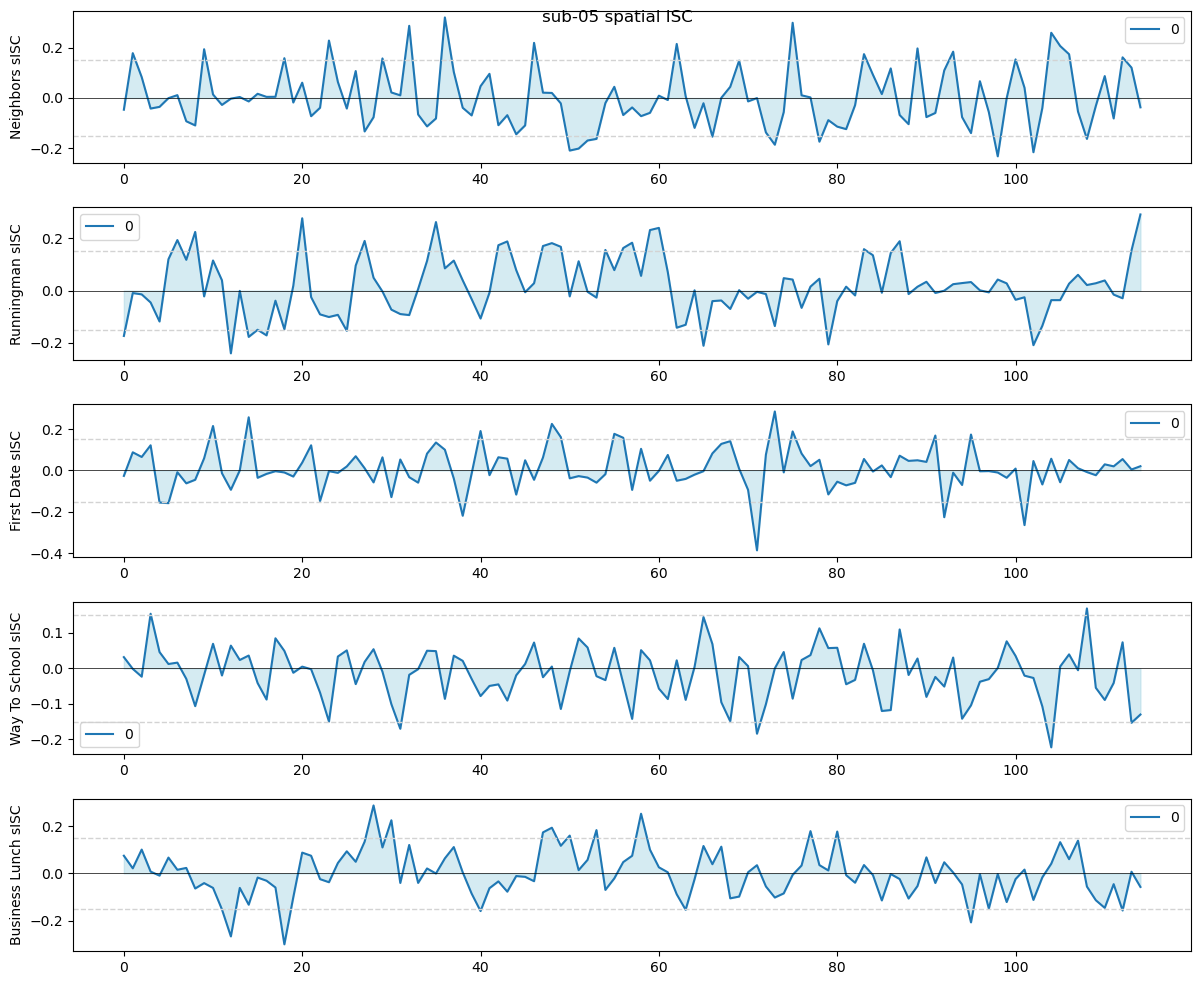

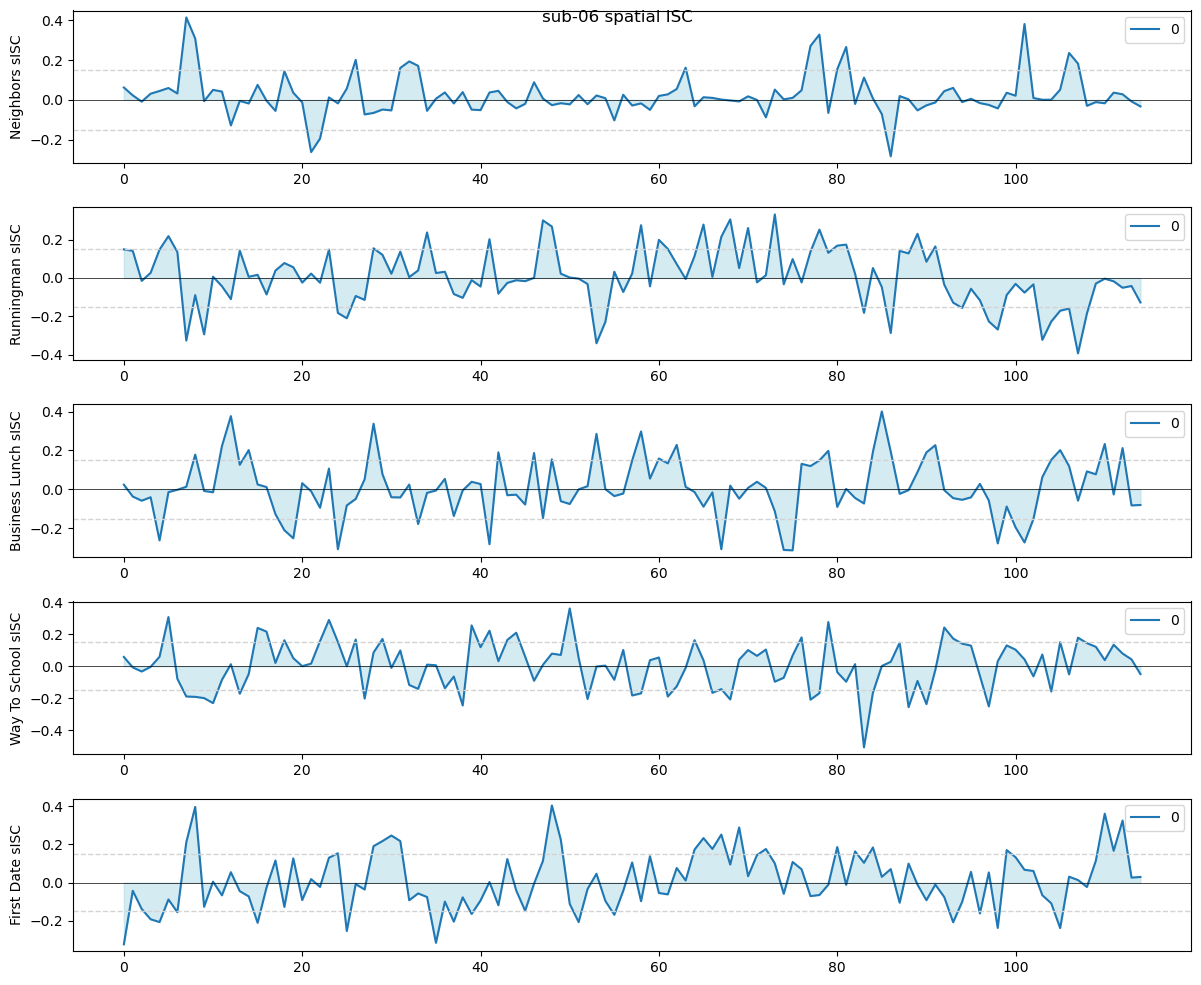

In [604]:
# plotting spatial ISC for each Subjects 
roi = 28 # hippocampus
#roi = 32
for sub in subjects:
    roi_isc = all_roi_isc[sub]
    story = All_story[sub]
    f,a = plt.subplots(5,1, figsize=(12,10))
    f.tight_layout()
    f.suptitle(f'sub-{sub} spatial ISC')
    for i in np.arange(0,5):   
        X = pd.DataFrame(roi_isc[i+1][roi]).index 
        pd.DataFrame(roi_isc[i+1][roi]).plot(ax=a[i])
        a[i].set_ylabel(f'{story[i]} sISC',fontsize=10)
        a[i].fill_between(X, 0,  pd.DataFrame(roi_isc[i+1][roi])[0], alpha=0.5, color = 'lightblue')
        a[i].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
        a[i].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
        a[i].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=0.5)
        #a[i].axvline(1.0, 0.2, 0.8, color='lightgray', linestyle='--', linewidth=2)
        #for t in np.arange(0,5): 
        #    a[i].axvline(TRs[story[i]][t], 0.0, 1.0, color='lightpink', linestyle='--', linewidth=2)
    plt.show()
    print("=========================================================================================================================================================================================")   

   
    #a[i].set_xlabel('Time',fontsize=16)

In [ ]:
    
pd.DataFrame(roi_isc[i+1][roi]).plot(ax=a[i])
a[i].set_ylabel(f'{story[i]} sISC',fontsize=10)
a[i].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[i].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[i].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=0.5)
#a[i].set_xlabel('Time',fontsize=16)

In [ ]:
# plotting spatial ISC for each Subjects 
sub = '05' 
roi = 28 # hippocampus]
roi_isc = all_roi_isc[sub]
# sub_titles = load (이야기 순서~~) 

f,a = plt.subplots(5,1, figsize=(15,10))
f.tight_layout()

roi_isc[1][roi].plot(ax=a[0])
a[0].set_ylabel('Neighbor sISC',fontsize=10)
a[0].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[0].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[0].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[0].set_xlabel('Time',fontsize=16)

roi_isc[2][roi].plot(ax=a[1])
a[1].set_ylabel('Runningman sISC',fontsize=10)
a[1].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[1].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[1].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[1].set_xlabel('Time',fontsize=16)

roi_isc[3][roi].plot(ax=a[2])
a[2].set_ylabel('BlindDate sISC',fontsize=10)
a[2].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[2].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[2].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[2].set_xlabel('Time',fontsize=16)

roi_isc[4][roi].plot(ax=a[3])
a[3].set_ylabel('School sISC',fontsize=10)
a[3].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[3].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[3].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[3].set_xlabel('Time',fontsize=16)

roi_isc[5][roi].plot(ax=a[4])
a[4].set_ylabel('Business sISC',fontsize=10)
a[4].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[4].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[4].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
a[4].set_xlabel('Time',fontsize=16)


## practice 1. sub-05

In [116]:
roi_isc1 = {}
roi_isc2 = {}
roi_isc3 = {}
roi_isc4 = {}
roi_isc5 = {}
for roi in tqdm(range(50)):
    file_list = glob.glob(os.path.join(Zdenoised_dir, 'Denoised_ROI',f'sub-05_task-encoding_run-*_denoised_roi{roi}.csv'))
    #print(file_list)
    all_run_dat = {}
    story1= {}
    story2= {}
    story3= {}
    story4= {}
    story5= {}
    for f in file_list:
        run = os.path.basename(f).split('_')[2]
        all_run_dat[run] = pd.read_csv(f)
        story1[run] = all_run_dat[run][11:126]
        story2[run] = all_run_dat[run][131:246]
        story3[run] = all_run_dat[run][251:366]
        story4[run] = all_run_dat[run][371:486]
        story5[run] = all_run_dat[run][491:604]
    isc1 = {}
    isc2 = {}
    isc3 = {}
    isc4 = {}
    isc5 = {}
    for i in range(115):
        time_dat1 = {}
        time_dat2 = {}
        time_dat3 = {}
        time_dat4 = {}
        #time_dat5 = {}
        for run in all_run_dat:
            time_dat1[run] = story1[run].iloc[i,:]
            time_dat2[run] = story2[run].iloc[i,:]
            time_dat3[run] = story3[run].iloc[i,:]
            time_dat4[run] = story4[run].iloc[i,:]
            #time_dat5[run] = story5[run].iloc[i,:]
        time_dat1 = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat1).T, metric='correlation'), matrix_type='similarity')
        time_dat2 = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat2).T, metric='correlation'), matrix_type='similarity')
        time_dat3 = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat3).T, metric='correlation'), matrix_type='similarity')
        time_dat4 = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat4).T, metric='correlation'), matrix_type='similarity')
        #time_dat5 = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat5).T, metric='correlation'), matrix_type='similarity')
        isc1[i] = time_dat1.median()
        isc2[i] = time_dat2.median()
        isc3[i] = time_dat3.median()
        isc4[i] = time_dat4.median()
        #isc5[i] = time_dat5.median()
    roi_isc1[roi] = isc1
    roi_isc2[roi] = isc2
    roi_isc3[roi] = isc3
    roi_isc4[roi] = isc4
    #roi_isc5[roi] = isc5
#pd.DataFrame(roi_isc1).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-05_task-encoding_Spatial_ISC1.csv'), index=False)
#pd.DataFrame(roi_isc2).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-05_task-encoding_Spatial_ISC2.csv'), index=False)
#pd.DataFrame(roi_isc3).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-05_task-encoding_Spatial_ISC3.csv'), index=False)
#pd.DataFrame(roi_isc4).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-05_task-encoding_Spatial_ISC4.csv'), index=False)
#pd.DataFrame(roi_isc5).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-05_task-encoding_Spatial_ISC5.csv'), index=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:44<00:00,  1.13it/s]


In [117]:
roi_isc5 = {}
for roi in tqdm(range(50)):
    file_list = glob.glob(os.path.join(Zdenoised_dir, 'Denoised_ROI',f'sub-05_task-encoding_run-*_denoised_roi{roi}.csv'))
    #print(file_list)
    all_run_dat = {}
    story5= {}
    for f in file_list:
        run = os.path.basename(f).split('_')[2]
        all_run_dat[run] = pd.read_csv(f)
        story5[run] = all_run_dat[run][489:604]
    isc5 = {}
    for i in range(115):
        time_dat5 = {}
        for run in all_run_dat:
            time_dat5[run] = story5[run].iloc[i,:]
        time_dat5 = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat5).T, metric='correlation'), matrix_type='similarity')
        isc5[i] = time_dat5.median()
    roi_isc5[roi] = isc5

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.66it/s]


In [24]:
roi_isc = {}
for roi in tqdm(range(50)):
    file_list = glob.glob(os.path.join(denoised_dir, 'Denoised_ROI',f'sub-05_task-encoding_run-*_denoised_roi{roi}.csv'))
    #print(file_list)
    all_run_dat = {}
    for f in file_list:
        run = os.path.basename(f).split('_')[2]
        all_run_dat[run] = pd.read_csv(f)
    isc = {}
    for i in range(604):
        time_dat = {}
        for run in all_run_dat:
            time_dat[run] = all_run_dat[run].iloc[i,:]
        time_dat = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat).T, metric='correlation'), matrix_type='similarity')
        isc[i] = time_dat.median()
    roi_isc[roi] = isc
pd.DataFrame(roi_isc1).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-05_task-encoding_Spatial_ISC.csv'), index=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.97it/s]


In [32]:
rois = pd.read_csv('https://raw.githubusercontent.com/naturalistic-data-analysis/tutorial_development/master/hypertools/rois.csv', header=None, names=['ID', 'Region'])
rois

,ID,Region
0,0,Anterior MPFC
1,1,Fusiform/parahippocampus
2,2,DMPFC
3,3,Sensorimotor/postcentral gyrus
4,4,V1
5,5,TPJ posterior supra marginal/angular gyrus
6,6,PCC/precuneus
7,7,Thalamus
8,8,SMA
9,9,Precentral gyrus


In [118]:
roi_isc1 = pd.DataFrame(roi_isc1)
roi_isc2 = pd.DataFrame(roi_isc2)
roi_isc3 = pd.DataFrame(roi_isc3)
roi_isc4 = pd.DataFrame(roi_isc4)
roi_isc5 = pd.DataFrame(roi_isc5)

Z1 = np.arctanh(roi_isc1)
Z2 = np.arctanh(roi_isc2)
Z3 = np.arctanh(roi_isc3)
Z4 = np.arctanh(roi_isc4)
Z5 = np.arctanh(roi_isc5)

story1 ISC: min = -0.233; max = 0.322
Z1 ISC: min = -0.237; max = 0.334
story2 ISC: min = -0.240; max = 0.277
Z2 ISC: min = -0.245; max = 0.284
story3 ISC: min = -0.386; max = 0.285
Z3 ISC: min = -0.407; max = 0.293
story4 ISC: min = -0.222; max = 0.169
Z4 ISC: min = -0.226; max = 0.171
story5 ISC: min = -0.300; max = 0.288
Z5 ISC: min = -0.310; max = 0.296


Text(0.5, 80.7222222222222, 'Time')

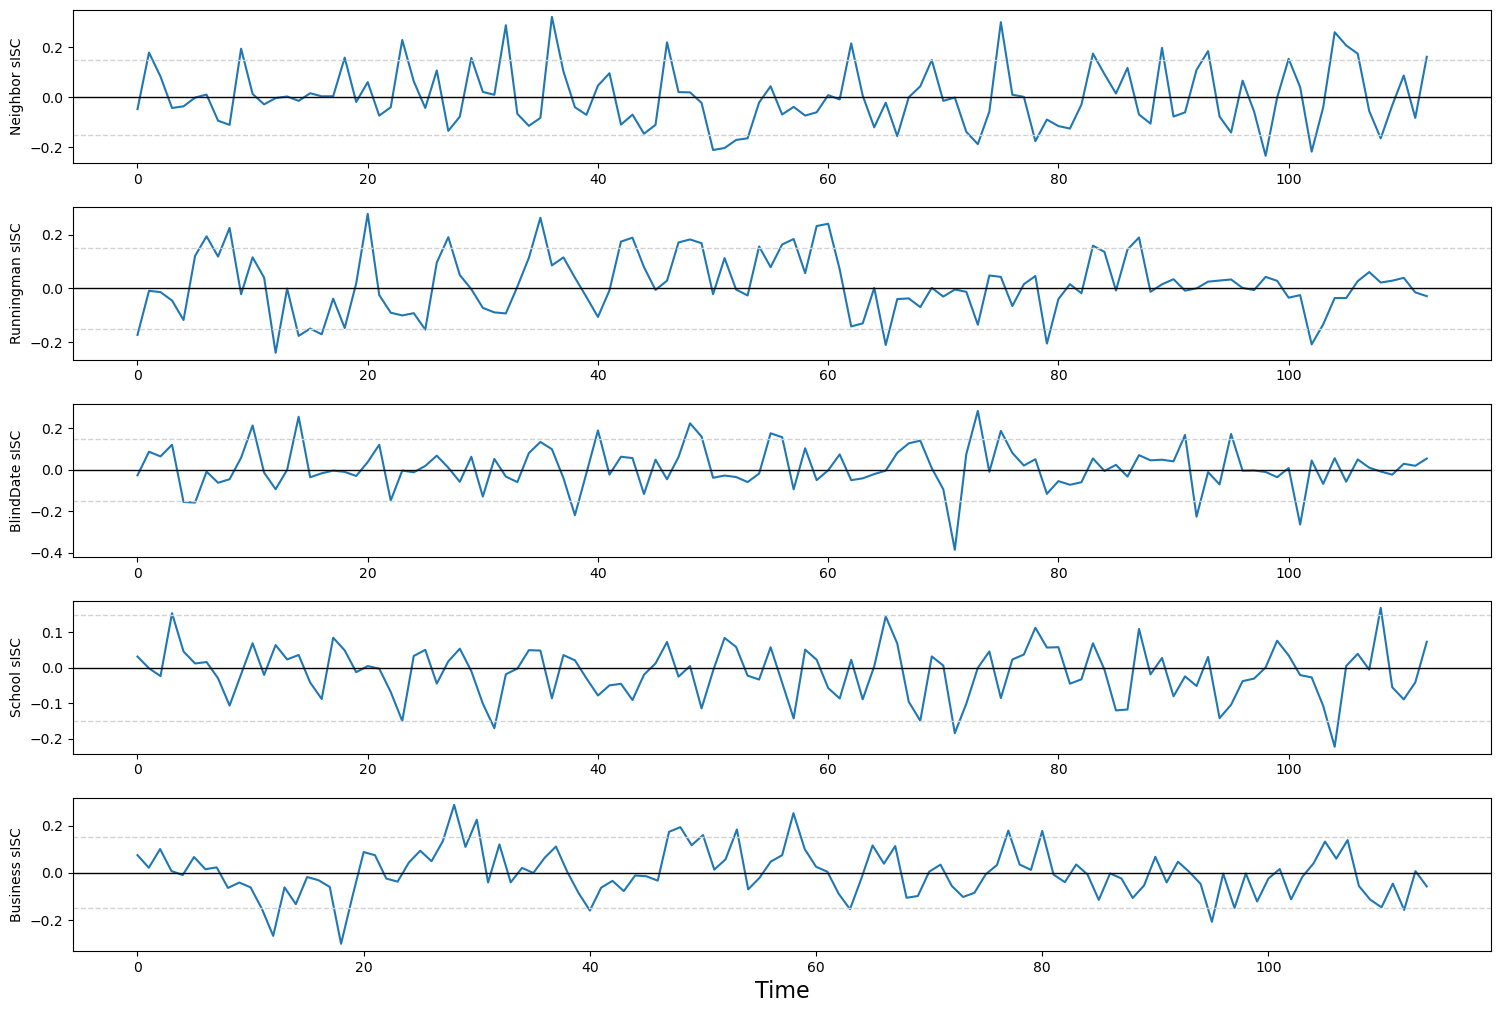

In [92]:
roi = 28
print("story1 ISC: min = %.3f; max = %.3f" % (roi_isc1[roi].min(), roi_isc1[roi].max()))
print("Z1 ISC: min = %.3f; max = %.3f" % (Z1[roi].min(), Z1[roi].max()))
print("story2 ISC: min = %.3f; max = %.3f" % (roi_isc2[roi].min(), roi_isc2[roi].max()))
print("Z2 ISC: min = %.3f; max = %.3f" % (Z2[roi].min(), Z2[roi].max()))
print("story3 ISC: min = %.3f; max = %.3f" % (roi_isc3[roi].min(), roi_isc3[roi].max()))
print("Z3 ISC: min = %.3f; max = %.3f" % (Z3[roi].min(), Z3[roi].max()))
print("story4 ISC: min = %.3f; max = %.3f" % (roi_isc4[roi].min(), roi_isc4[roi].max()))
print("Z4 ISC: min = %.3f; max = %.3f" % (Z4[roi].min(), Z4[roi].max()))
print("story5 ISC: min = %.3f; max = %.3f" % (roi_isc5[roi].min(), roi_isc5[roi].max()))
print("Z5 ISC: min = %.3f; max = %.3f" % (Z5[roi].min(), Z5[roi].max()))


f,a = plt.subplots(5,1, figsize=(15,10))
f.tight_layout()

roi_isc1[roi].plot(ax=a[0])
a[0].set_ylabel('Neighbor sISC',fontsize=10)
a[0].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[0].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[0].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[0].set_xlabel('Time',fontsize=16)

roi_isc2[roi].plot(ax=a[1])
a[1].set_ylabel('Runningman sISC',fontsize=10)
a[1].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[1].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[1].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[1].set_xlabel('Time',fontsize=16)

roi_isc3[roi].plot(ax=a[2])
a[2].set_ylabel('BlindDate sISC',fontsize=10)
a[2].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[2].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[2].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[2].set_xlabel('Time',fontsize=16)

roi_isc4[roi].plot(ax=a[3])
a[3].set_ylabel('School sISC',fontsize=10)
a[3].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[3].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[3].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[3].set_xlabel('Time',fontsize=16)

roi_isc5[roi].plot(ax=a[4])
a[4].set_ylabel('Business sISC',fontsize=10)
a[4].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[4].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[4].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
a[4].set_xlabel('Time',fontsize=16)


In [86]:
roi = 28
print("Neighbor averaged ISCs: min = %.3f" % (roi_isc1[roi].mean())) #neigh
print("Runningman averaged ISCs: min = %.3f" % (roi_isc2[roi].mean()))
print("BlindDate averaged ISCs: min = %.3f" % (roi_isc3[roi].mean()))
print("WayToSchool averaged ISCs: min = %.3f" % (roi_isc4[roi].mean()))
print("BusinessLunch averaged ISCs: min = %.3f" % (roi_isc5[roi].mean()))

Neighbor averaged ISCs: min = 0.001
Runningman averaged ISCs: min = 0.014
BlindDate averaged ISCs: min = 0.011
WayToSchool averaged ISCs: min = -0.012
BusinessLunch averaged ISCs: min = 0.001


spatial ISC 
- (+) : first > second 
- (-) : first < second

(+) 인 timepoint 와 (-) 인 timepoint  comapare with Dynamic Counting !!

Text(0.5, 0, 'Time')

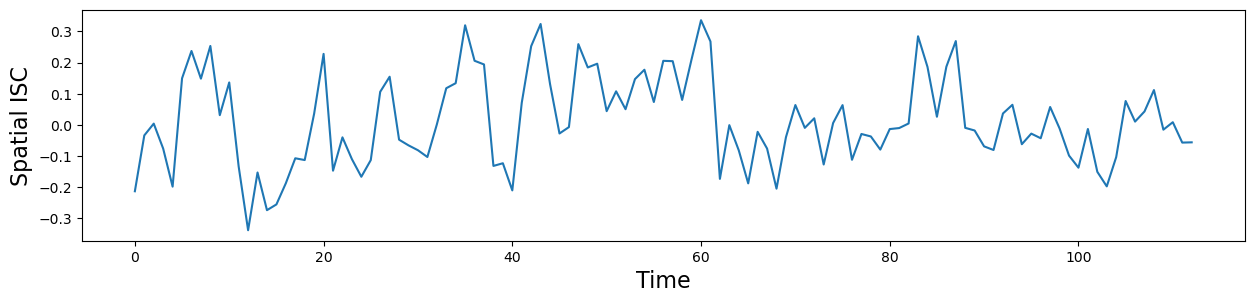

In [60]:
roi_isc1 = pd.DataFrame(roi_isc1)
roi_isc2 = pd.DataFrame(roi_isc2)

f,a = plt.subplots(figsize=(15,3))
roi_isc2[12].plot(ax=a)
a.set_ylabel('Spatial ISC',fontsize=16)
a.set_xlabel('Time',fontsize=16)


## practice 2. sub-06

In [112]:
roi_isc1 = {}
roi_isc2 = {}
roi_isc3 = {}
roi_isc4 = {}
#roi_isc5 = {}
for roi in tqdm(range(50)):
    file_list = glob.glob(os.path.join(Zdenoised_dir, 'Denoised_ROI',f'sub-08_task-encoding_run-[3-4]_denoised_roi{roi}.csv'))
    #print(file_list)
    all_run_dat = {}
    story1= {}
    story2= {}
    story3= {}
    story4= {}
    #story5= {}
    for f in file_list:
        run = os.path.basename(f).split('_')[2]
        all_run_dat[run] = pd.read_csv(f)
        #story1[run] = all_run_dat[run][11:126]
        #story2[run] = all_run_dat[run][131:246]
        #story3[run] = all_run_dat[run][251:366]
        #story4[run] = all_run_dat[run][371:476]
        story1[run] = all_run_dat[run][0:116]
        story2[run] = all_run_dat[run][120:236]
        story3[run] = all_run_dat[run][240:356]
        story4[run] = all_run_dat[run][360:476]
        
        #story5[run] = all_run_dat[run][489:604]
    isc1 = {}
    isc2 = {}
    isc3 = {}
    isc4 = {}
    #isc5 = {}
    for i in range(112):
        time_dat1 = {}
        time_dat2 = {}
        time_dat3 = {}
        time_dat4 = {}
        #time_dat5 = {}
        for run in all_run_dat:
            time_dat1[run] = story1[run].iloc[i,:]
            time_dat2[run] = story2[run].iloc[i,:]
            time_dat3[run] = story3[run].iloc[i,:]
            time_dat4[run] = story4[run].iloc[i,:]
            #time_dat5[run] = story5[run].iloc[i,:]
        time_dat1 = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat1).T, metric='correlation'), matrix_type='similarity')
        time_dat2 = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat2).T, metric='correlation'), matrix_type='similarity')
        time_dat3 = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat3).T, metric='correlation'), matrix_type='similarity')
        time_dat4 = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat4).T, metric='correlation'), matrix_type='similarity')
        #time_dat5 = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat5).T, metric='correlation'), matrix_type='similarity')
        isc1[i] = time_dat1.median()
        isc2[i] = time_dat2.median()
        isc3[i] = time_dat3.median()
        isc4[i] = time_dat4.median()
        #isc5[i] = time_dat5.median()
    roi_isc1[roi] = isc1
    roi_isc2[roi] = isc2
    roi_isc3[roi] = isc3
    roi_isc4[roi] = isc4
    #roi_isc5[roi] = isc5
#pd.DataFrame(roi_isc1).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-05_task-encoding_Spatial_ISC1.csv'), index=False)
#pd.DataFrame(roi_isc2).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-05_task-encoding_Spatial_ISC2.csv'), index=False)
#pd.DataFrame(roi_isc3).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-05_task-encoding_Spatial_ISC3.csv'), index=False)
#pd.DataFrame(roi_isc4).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-05_task-encoding_Spatial_ISC4.csv'), index=False)
#pd.DataFrame(roi_isc5).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-05_task-encoding_Spatial_ISC5.csv'), index=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


In [113]:
roi_isc1 = pd.DataFrame(roi_isc1)
roi_isc2 = pd.DataFrame(roi_isc2)
roi_isc3 = pd.DataFrame(roi_isc3)
roi_isc4 = pd.DataFrame(roi_isc4)
#roi_isc5 = pd.DataFrame(roi_isc5)

Z1 = np.arctanh(roi_isc1)
Z2 = np.arctanh(roi_isc2)
Z3 = np.arctanh(roi_isc3)
Z4 = np.arctanh(roi_isc4)
#Z5 = np.arctanh(roi_isc5)

story1 ISC: min = -0.395; max = 0.439
Z1 ISC: min = -0.417; max = 0.470
story2 ISC: min = -0.438; max = 0.503
Z2 ISC: min = -0.469; max = 0.553
story3 ISC: min = -0.441; max = 0.484
Z3 ISC: min = -0.473; max = 0.529
story4 ISC: min = -0.401; max = 0.414
Z4 ISC: min = -0.425; max = 0.440
-----------------------mean--------------------------
King averaged ISCs: Mean = 0.009
Runningman averaged ISCs: Mean = 0.030
Neighbors averaged ISCs: Mean = 0.046
Twoboys averaged ISCs: Mean = 0.014
-----------------------Plot--------------------------


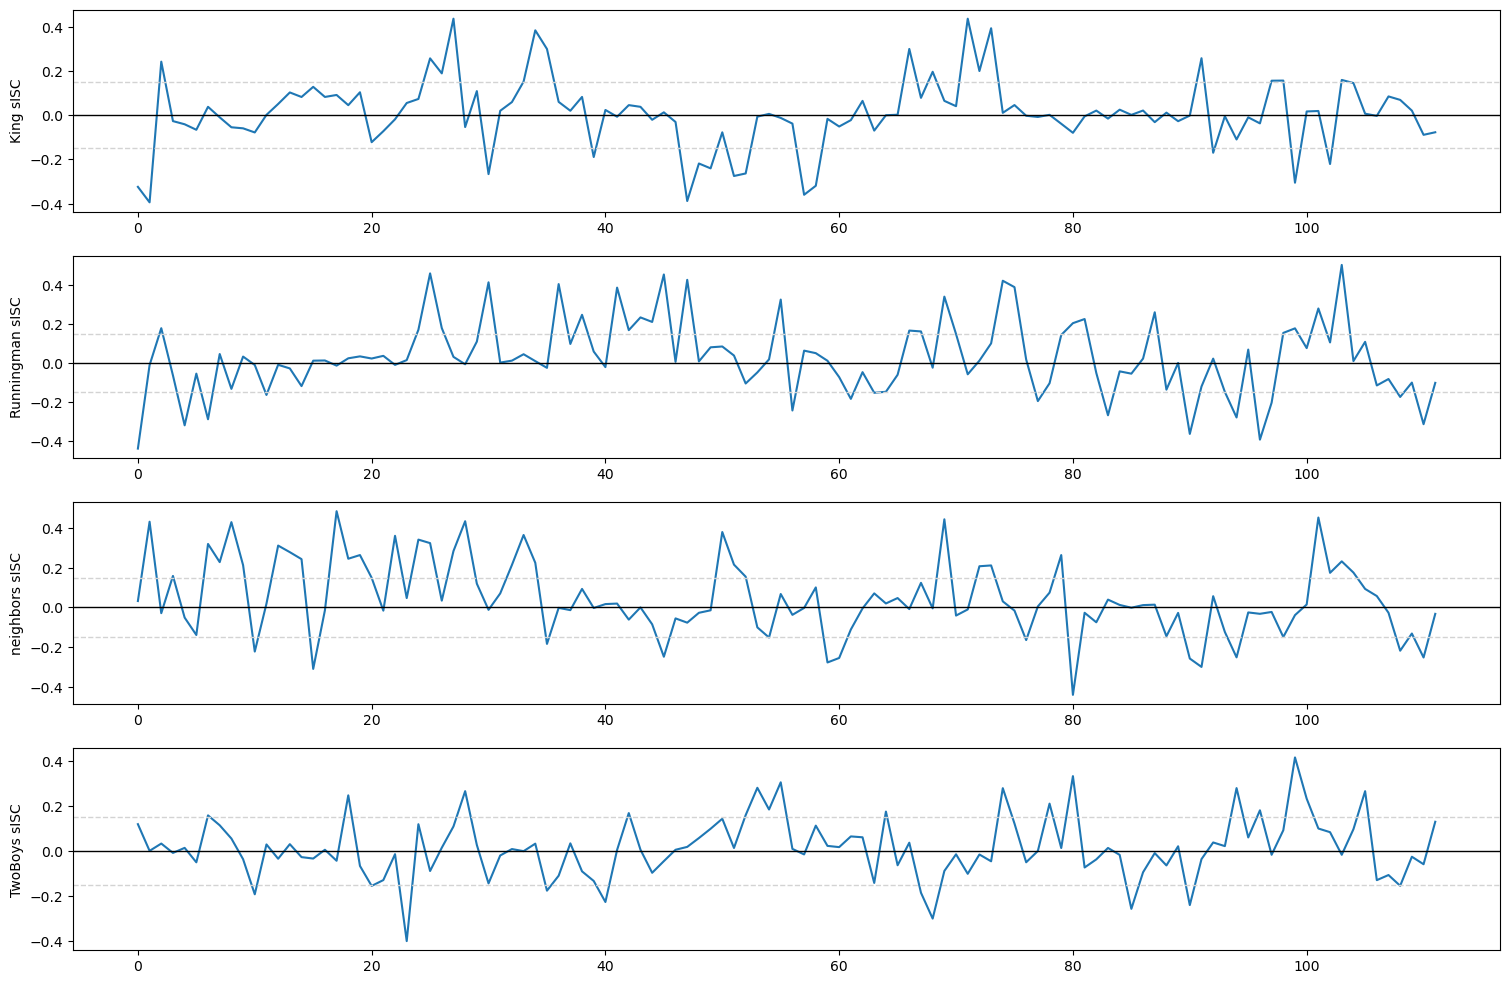

In [117]:
#sub-08, Run-2
roi = 28
print("story1 ISC: min = %.3f; max = %.3f" % (roi_isc1[roi].min(), roi_isc1[roi].max()))
print("Z1 ISC: min = %.3f; max = %.3f" % (Z1[roi].min(), Z1[roi].max()))
print("story2 ISC: min = %.3f; max = %.3f" % (roi_isc2[roi].min(), roi_isc2[roi].max()))
print("Z2 ISC: min = %.3f; max = %.3f" % (Z2[roi].min(), Z2[roi].max()))
print("story3 ISC: min = %.3f; max = %.3f" % (roi_isc3[roi].min(), roi_isc3[roi].max()))
print("Z3 ISC: min = %.3f; max = %.3f" % (Z3[roi].min(), Z3[roi].max()))
print("story4 ISC: min = %.3f; max = %.3f" % (roi_isc4[roi].min(), roi_isc4[roi].max()))
print("Z4 ISC: min = %.3f; max = %.3f" % (Z4[roi].min(), Z4[roi].max()))
#print("story5 ISC: min = %.3f; max = %.3f" % (roi_isc5[roi].min(), roi_isc5[roi].max()))
#print("Z5 ISC: min = %.3f; max = %.3f" % (Z5[roi].min(), Z5[roi].max()))


f,a = plt.subplots(4,1, figsize=(15,10))
f.tight_layout()

roi_isc1[roi].plot(ax=a[0])
a[0].set_ylabel('King sISC',fontsize=10)
a[0].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[0].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[0].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[0].set_xlabel('Time',fontsize=16)

roi_isc2[roi].plot(ax=a[1])
a[1].set_ylabel('Runningman sISC',fontsize=10)
a[1].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[1].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[1].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[1].set_xlabel('Time',fontsize=16)

roi_isc3[roi].plot(ax=a[2])
a[2].set_ylabel('neighbors sISC',fontsize=10)
a[2].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[2].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[2].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[2].set_xlabel('Time',fontsize=16)

roi_isc4[roi].plot(ax=a[3])
a[3].set_ylabel('TwoBoys sISC',fontsize=10)
a[3].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[3].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[3].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[3].set_xlabel('Time',fontsize=16)

#roi_isc5[roi].plot(ax=a[4])
#a[4].set_ylabel('Business sISC',fontsize=10)
#a[4].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
#a[4].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
#a[4].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[4].set_xlabel('Time',fontsize=16)

print('-----------------------mean--------------------------')

print("King averaged ISCs: Mean = %.3f" % (roi_isc1[roi].mean())) #neigh
print("Runningman averaged ISCs: Mean = %.3f" % (roi_isc2[roi].mean()))
print("Neighbors averaged ISCs: Mean = %.3f" % (roi_isc3[roi].mean()))
print("Twoboys averaged ISCs: Mean = %.3f" % (roi_isc4[roi].mean()))
print('-----------------------Plot--------------------------')
#print("BusinessLunch averaged ISCs: min = %.3f" % (roi_isc5[roi].mean()))


story1 ISC: min = -0.455; max = 0.345
Z1 ISC: min = -0.491; max = 0.359
story2 ISC: min = -0.306; max = 0.349
Z2 ISC: min = -0.316; max = 0.365
story3 ISC: min = -0.538; max = 0.456
Z3 ISC: min = -0.601; max = 0.493
story4 ISC: min = -0.412; max = 0.406
Z4 ISC: min = -0.438; max = 0.431


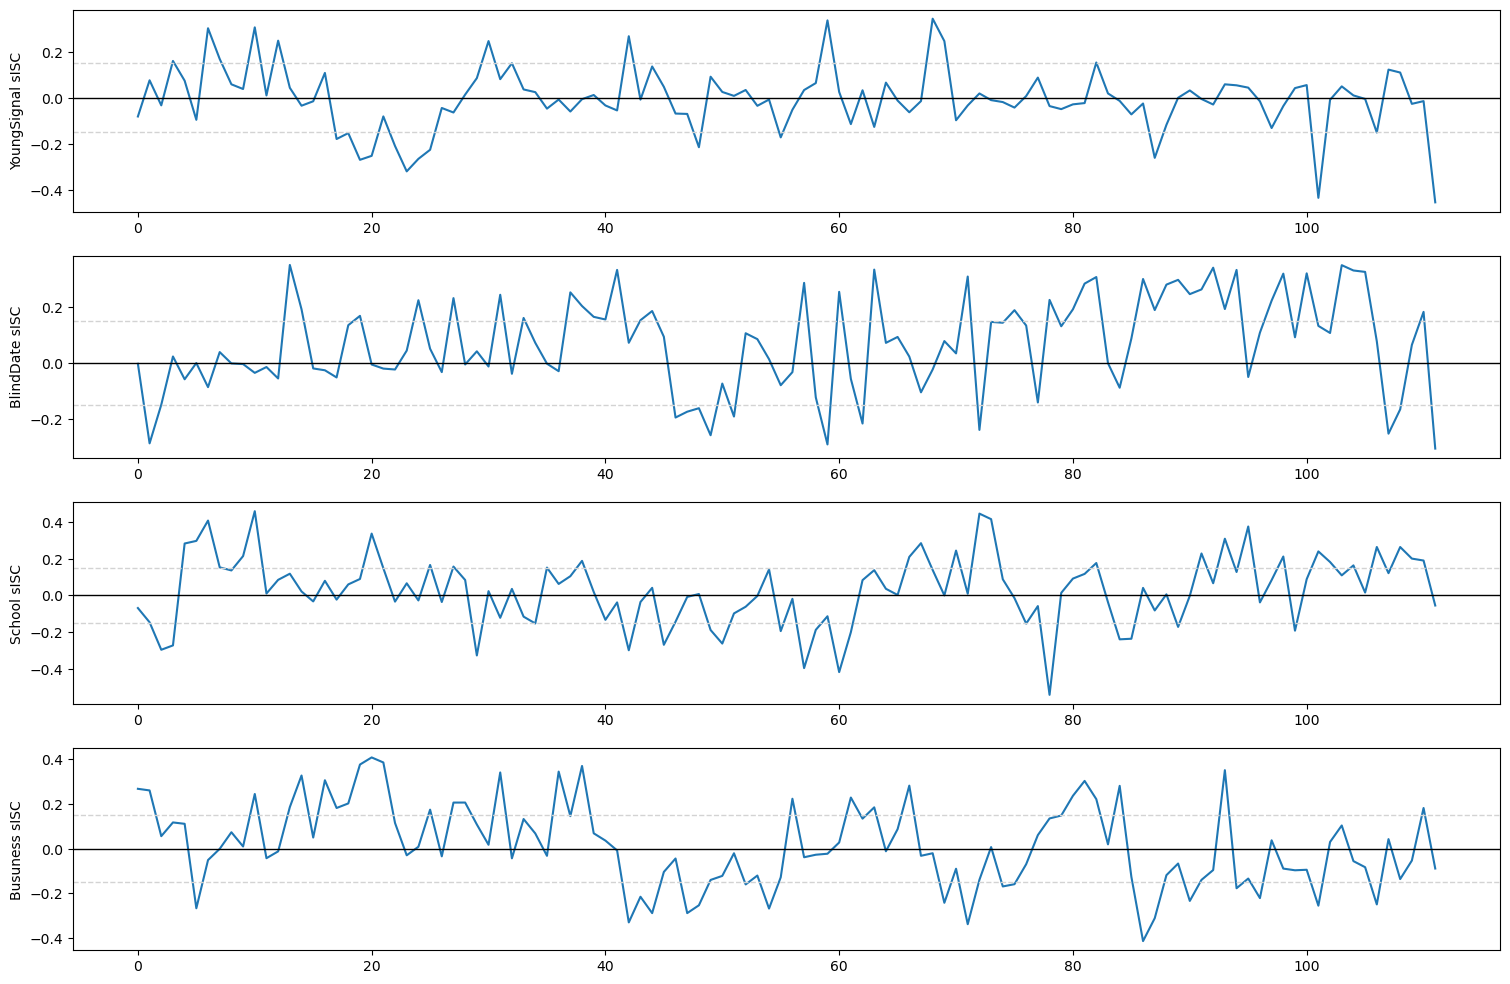

In [110]:
#sub-08, Run-1
roi = 28
print("story1 ISC: min = %.3f; max = %.3f" % (roi_isc1[roi].min(), roi_isc1[roi].max()))
print("Z1 ISC: min = %.3f; max = %.3f" % (Z1[roi].min(), Z1[roi].max()))
print("story2 ISC: min = %.3f; max = %.3f" % (roi_isc2[roi].min(), roi_isc2[roi].max()))
print("Z2 ISC: min = %.3f; max = %.3f" % (Z2[roi].min(), Z2[roi].max()))
print("story3 ISC: min = %.3f; max = %.3f" % (roi_isc3[roi].min(), roi_isc3[roi].max()))
print("Z3 ISC: min = %.3f; max = %.3f" % (Z3[roi].min(), Z3[roi].max()))
print("story4 ISC: min = %.3f; max = %.3f" % (roi_isc4[roi].min(), roi_isc4[roi].max()))
print("Z4 ISC: min = %.3f; max = %.3f" % (Z4[roi].min(), Z4[roi].max()))
#print("story5 ISC: min = %.3f; max = %.3f" % (roi_isc5[roi].min(), roi_isc5[roi].max()))
#print("Z5 ISC: min = %.3f; max = %.3f" % (Z5[roi].min(), Z5[roi].max()))


f,a = plt.subplots(4,1, figsize=(15,10))
f.tight_layout()

roi_isc1[roi].plot(ax=a[0])
a[0].set_ylabel('YoungSignal sISC',fontsize=10)
a[0].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[0].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[0].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[0].set_xlabel('Time',fontsize=16)

roi_isc2[roi].plot(ax=a[1])
a[1].set_ylabel('BlindDate sISC',fontsize=10)
a[1].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[1].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[1].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[1].set_xlabel('Time',fontsize=16)

roi_isc3[roi].plot(ax=a[2])
a[2].set_ylabel('School sISC',fontsize=10)
a[2].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[2].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[2].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[2].set_xlabel('Time',fontsize=16)

roi_isc4[roi].plot(ax=a[3])
a[3].set_ylabel('Busuness sISC',fontsize=10)
a[3].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[3].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[3].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[3].set_xlabel('Time',fontsize=16)

#roi_isc5[roi].plot(ax=a[4])
#a[4].set_ylabel('Business sISC',fontsize=10)
#a[4].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
#a[4].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
#a[4].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[4].set_xlabel('Time',fontsize=16)


In [111]:
roi = 28
print("YoungSignal averaged ISCs: min = %.3f" % (roi_isc1[roi].mean())) #neigh
print("BlindDate averaged ISCs: min = %.3f" % (roi_isc2[roi].mean()))
print("Dance averaged ISCs: min = %.3f" % (roi_isc3[roi].mean()))
print("BusinessLunch averaged ISCs: min = %.3f" % (roi_isc4[roi].mean()))
#print("BusinessLunch averaged ISCs: min = %.3f" % (roi_isc5[roi].mean()))

YoungSignal averaged ISCs: min = -0.007
BlindDate averaged ISCs: min = 0.071
Dance averaged ISCs: min = 0.030
BusinessLunch averaged ISCs: min = 0.014


story1 ISC: min = -0.284; max = 0.414
Z1 ISC: min = -0.292; max = 0.441
story2 ISC: min = -0.392; max = 0.331
Z2 ISC: min = -0.414; max = 0.344
story3 ISC: min = -0.313; max = 0.400
Z3 ISC: min = -0.324; max = 0.424
story4 ISC: min = -0.506; max = 0.361
Z4 ISC: min = -0.558; max = 0.378
story5 ISC: min = -0.323; max = 0.404
Z5 ISC: min = -0.335; max = 0.429


Text(0.5, 80.7222222222222, 'Time')

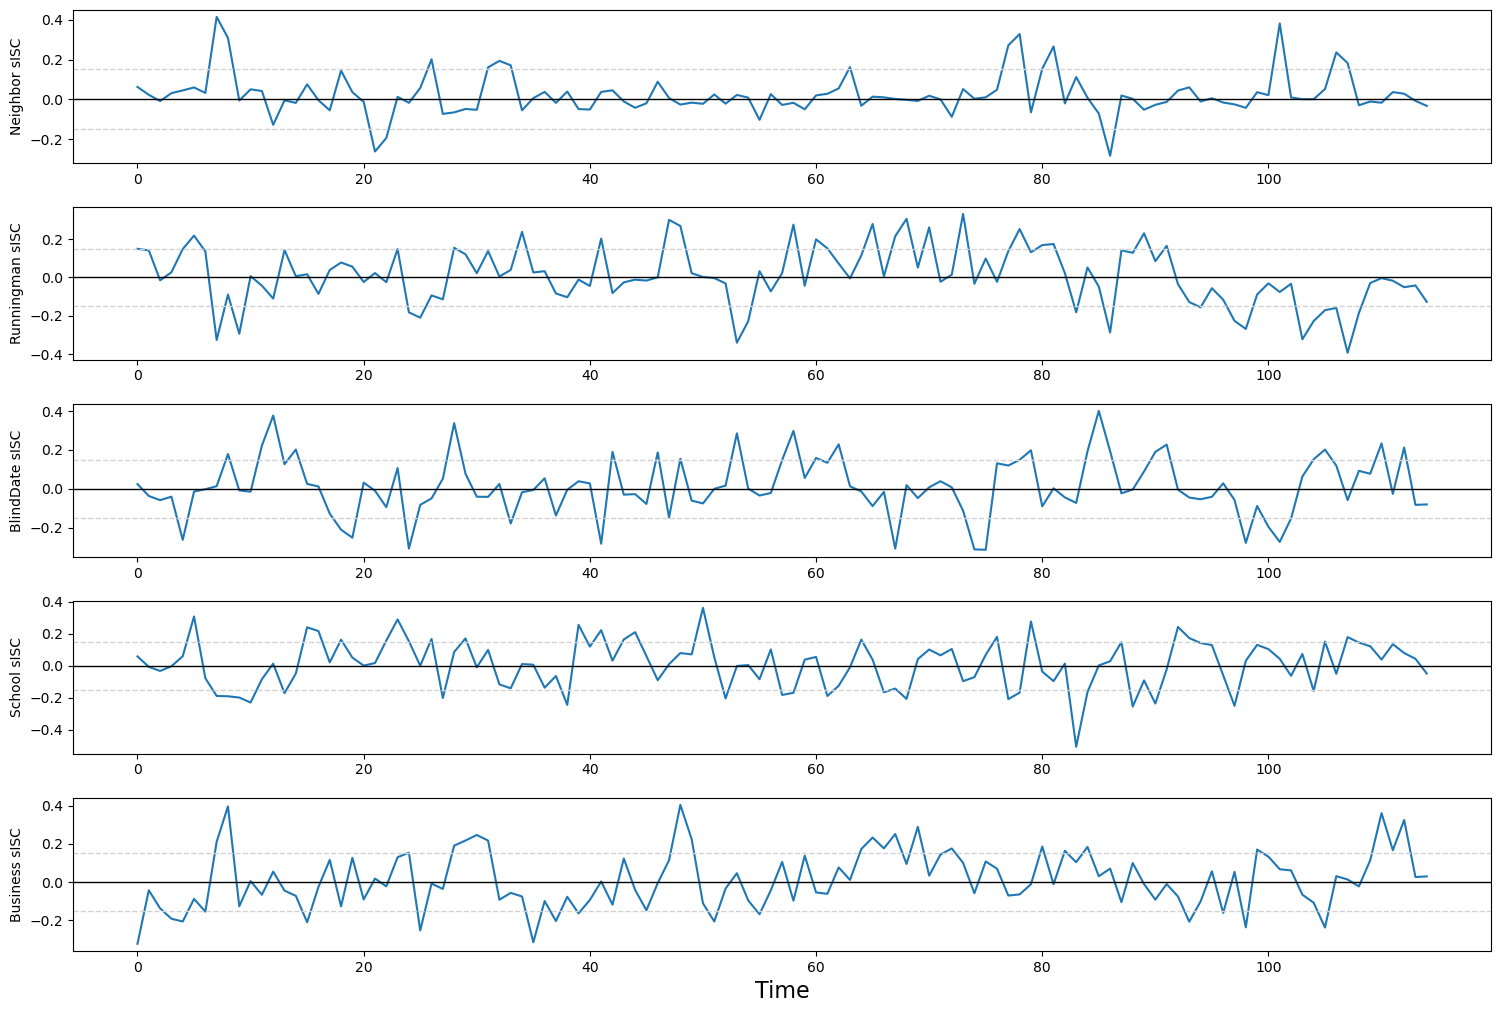

In [97]:
#sub-06
roi = 28
print("story1 ISC: min = %.3f; max = %.3f" % (roi_isc1[roi].min(), roi_isc1[roi].max()))
print("Z1 ISC: min = %.3f; max = %.3f" % (Z1[roi].min(), Z1[roi].max()))
print("story2 ISC: min = %.3f; max = %.3f" % (roi_isc2[roi].min(), roi_isc2[roi].max()))
print("Z2 ISC: min = %.3f; max = %.3f" % (Z2[roi].min(), Z2[roi].max()))
print("story3 ISC: min = %.3f; max = %.3f" % (roi_isc3[roi].min(), roi_isc3[roi].max()))
print("Z3 ISC: min = %.3f; max = %.3f" % (Z3[roi].min(), Z3[roi].max()))
print("story4 ISC: min = %.3f; max = %.3f" % (roi_isc4[roi].min(), roi_isc4[roi].max()))
print("Z4 ISC: min = %.3f; max = %.3f" % (Z4[roi].min(), Z4[roi].max()))
print("story5 ISC: min = %.3f; max = %.3f" % (roi_isc5[roi].min(), roi_isc5[roi].max()))
print("Z5 ISC: min = %.3f; max = %.3f" % (Z5[roi].min(), Z5[roi].max()))


f,a = plt.subplots(5,1, figsize=(15,10))
f.tight_layout()

roi_isc1[roi].plot(ax=a[0])
a[0].set_ylabel('Neighbor sISC',fontsize=10)
a[0].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[0].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[0].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[0].set_xlabel('Time',fontsize=16)

roi_isc2[roi].plot(ax=a[1])
a[1].set_ylabel('Runningman sISC',fontsize=10)
a[1].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[1].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[1].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[1].set_xlabel('Time',fontsize=16)

roi_isc3[roi].plot(ax=a[2])
a[2].set_ylabel('BlindDate sISC',fontsize=10)
a[2].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[2].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[2].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[2].set_xlabel('Time',fontsize=16)

roi_isc4[roi].plot(ax=a[3])
a[3].set_ylabel('School sISC',fontsize=10)
a[3].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[3].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[3].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
#a[3].set_xlabel('Time',fontsize=16)

roi_isc5[roi].plot(ax=a[4])
a[4].set_ylabel('Business sISC',fontsize=10)
a[4].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[4].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
a[4].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
a[4].set_xlabel('Time',fontsize=16)


In [98]:
roi = 28
print("Neighbor averaged ISCs: min = %.3f" % (roi_isc1[roi].mean())) #neigh
print("Runningman averaged ISCs: min = %.3f" % (roi_isc2[roi].mean()))
print("BlindDate averaged ISCs: min = %.3f" % (roi_isc3[roi].mean()))
print("WayToSchool averaged ISCs: min = %.3f" % (roi_isc4[roi].mean()))
print("BusinessLunch averaged ISCs: min = %.3f" % (roi_isc5[roi].mean()))

Neighbor averaged ISCs: min = 0.024
Runningman averaged ISCs: min = 0.007
BlindDate averaged ISCs: min = 0.011
WayToSchool averaged ISCs: min = 0.009
BusinessLunch averaged ISCs: min = 0.012


## 전체 이야기에 대한 전체 참가자들의 spatial ISC

In [565]:
#Encoding 에 대해서만 비교하는 거니깐,,, 
roi = 28
subjects = ['05', '06']
#subjects = ['08']

sub_roi_isc = {}
for sub in subjects:
    roi_isc = {}
    for roi in tqdm(range(50)):
        file_list = glob.glob(os.path.join(denoised_dir, 'Denoised_ROI',f'sub-{sub}_task-encoding_run-*_denoised_roi{roi}.csv'))
        #print(file_list)
        all_run_dat = {}
        for f in file_list:
            run = os.path.basename(f).split('_')[2]
            all_run_dat[run] = pd.read_csv(f)
        isc = {}
        #for i in range(476):
        for i in range(604):
            time_dat = {}
            for run in all_run_dat:
                time_dat[run] = all_run_dat[run].iloc[i,:]
            time_dat = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat).T, metric='correlation'), matrix_type='similarity')
            isc[i] = time_dat.median()
        roi_isc[roi] = isc
    sub_roi_isc[sub] = roi_isc
    pd.DataFrame(roi_isc).to_csv(os.path.join(base_dir, 'analysis', 'ISC', f'sub-{sub}_task-encoding_Spatial_ISC.csv'), index=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.77it/s]


In [566]:
sub5 = pd.DataFrame(sub_roi_isc['05'])
sub6 = pd.DataFrame(sub_roi_isc['06'])
#sub3 = pd.DataFrame(sub_roi_isc['03'])
#sub8 = pd.DataFrame(sub_roi_isc['08'])
#sub4 = pd.DataFrame(sub_roi_isc['04'])


Z5 = np.arctanh(sub5)
Z6 = np.arctanh(sub6)
#Z8 = np.arctanh(sub8)
#Z4 = np.arctanh(sub4)


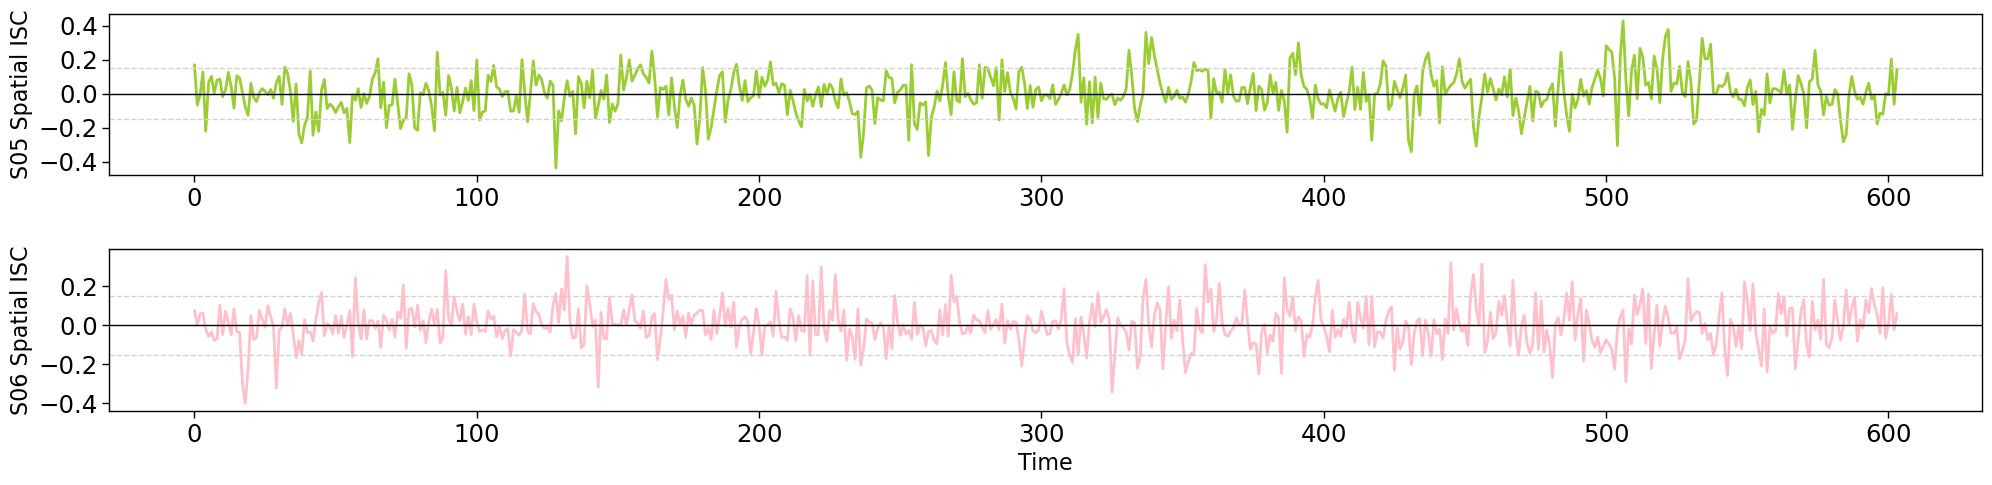

In [569]:
with sns.plotting_context(context='paper',font_scale=2):
    f,a = plt.subplots(2,1, figsize=(20,5))
    f.tight_layout()
    Z5[28].plot(ax=a[0],linewidth=2,color=['yellowgreen'],legend=False)
    Z6[28].plot(ax=a[1],linewidth=2,color=['pink'],legend=False)
    a[0].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
    a[0].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
    a[0].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
    a[0].set_ylabel('S05 Spatial ISC',fontsize=16)
    a[1].axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
    a[1].axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
    a[1].axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
    a[1].set_ylabel('S06 Spatial ISC',fontsize=16)
    a[1].set_xlabel('Time',fontsize=16)


In [ ]:
print("mean of spatial ISC =%.3f" % (roi_isc5[roi].mean()))
mean = (Z5 + Z6)/2

with sns.plotting_context(context='paper',font_scale=2):
    f,a = plt.subplots(1, figsize=(20,5))
    mean[28].plot(ax=a,linewidth=2,color=['pink'],legend=False)
    a.axhline(0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
    a.axhline(-0.15, 0, 110, color='lightgray', linestyle='--', linewidth=1)
    a.axhline(0, 0, 110, color='black', linestyle='solid', linewidth=1)
    a.set_ylabel('Spatial ISC',fontsize=16)
    a.set_xlabel('Time',fontsize=16)

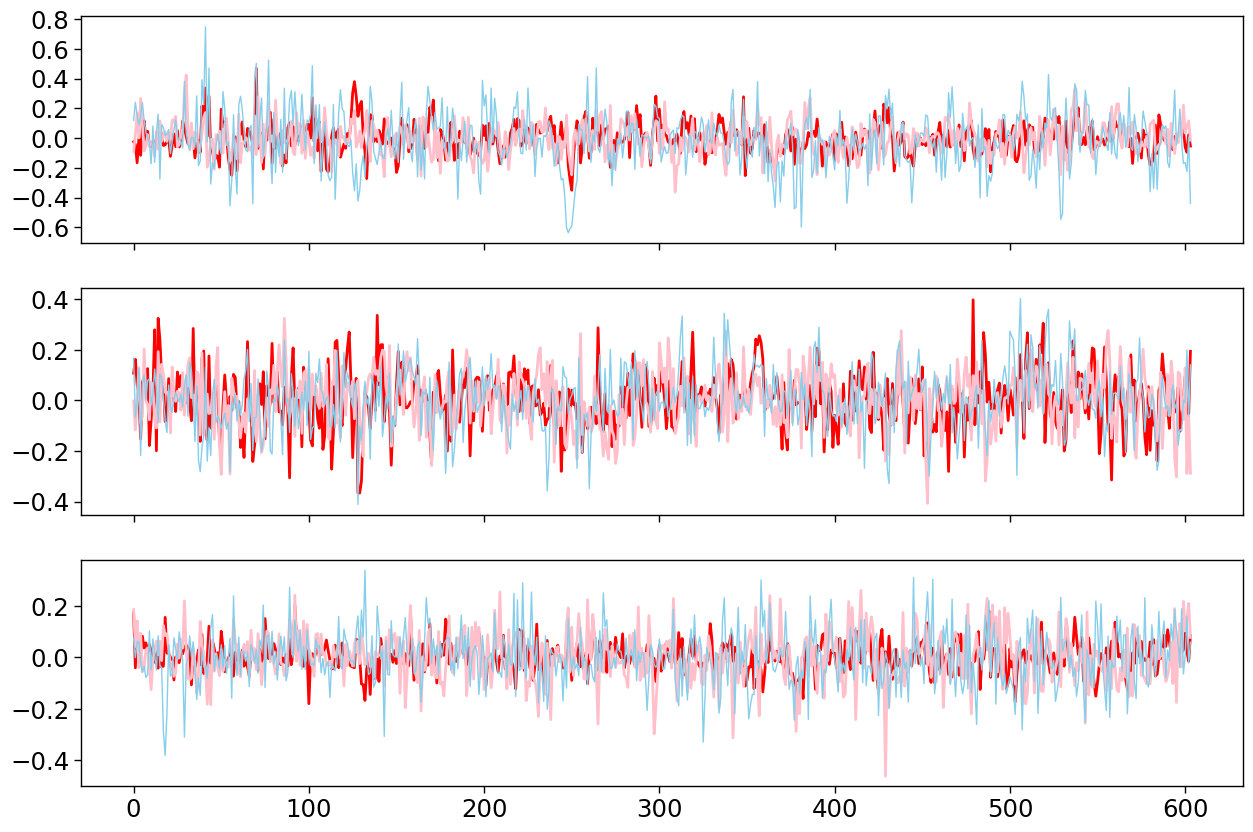

In [94]:
with sns.plotting_context(context='paper',font_scale=2):
    f,a = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
    sub4[1].plot(ax=a[0],linewidth=2,color=['red'],legend=False)
    sub4[32].plot(ax=a[0],linewidth=2,color=['pink'],legend=False)
    sub4[28].plot(ax=a[0],linewidth=1,color=['skyblue'],legend=False)
    # a[0].set_yticks([x for x in np.arange(0, 1., .2)])
    # a[0].set_yticklabels(['{0:.2f}'.format(x) for x in a[0].get_yticks()],
    #                      rotation=0,fontsize=18)
    # a[0].set_xticks(range(sub4.index.min(), sub4.index.max(), 50))
    # a[0].set_xticklabels(rec_to_time(range(sub4.index.min(), sub4.index.max(),50), TR=2.0),
    #                      rotation=60,fontsize=18)
    # a[0].set_ylim([0,1])

    sub5[1].plot(ax=a[1],linewidth=2,color=['red'],legend=False)
    sub5[32].plot(ax=a[1],linewidth=2,color=['pink'],legend=False)
    sub5[28].plot(ax=a[1],linewidth=1,color=['skyblue'],legend=False)
    # a[1].set_yticks([x for x in np.arange(0, 1., .2)])
    # a[1].set_yticklabels(['{0:.2f}'.format(x) for x in a[0].get_yticks()],
    #                      rotation=0,fontsize=18)
    # a[1].set_xticks(range(sub4.index.min(), sub4.index.max(), 50))
    # a[1].set_xticklabels(rec_to_time(range(sub4.index.min(), sub4.index.max(),50), TR=2.0),
    #                      rotation=60,fontsize=18)
    # a[1].set_ylim([0,1])

    sub6[1].plot(ax=a[2],linewidth=2,color=['red'],legend=False)
    sub6[32].plot(ax=a[2],linewidth=2,color=['pink'],legend=False)
    sub6[28].plot(ax=a[2],linewidth=1,color=['skyblue'],legend=False)
    # a[2].set_yticks([x for x in np.arange(0, 1., .2)])
    # a[2].set_yticklabels(['{0:.2f}'.format(x) for x in a[0].get_yticks()],
    #                      rotation=0,fontsize=18)
    # a[2].set_xticks(range(sub4.index.min(), sub4.index.max(), 50))
    # a[2].set_xticklabels(rec_to_time(range(sub4.index.min(), sub4.index.max(),50), TR=2.0),
    #                      rotation=60,fontsize=18)
    # a[2].set_ylim([0,1])


    #a.set_ylabel('Spatial ISC',fontsize=16)
    #a.set_xlabel('Time',fontsize=16)

# Load behavior results : Dynamic counting

- (1) Dynamic Counting Rubric에서 개별 장면이 시작하는 timepoint 기입 
- (2) 개별 장면에서의 Update Probability와 timepoint 정보 load 
- (3) 개별 장면 구간 (Onsett~ 다음 장면이 시작하기 전까지) 마다 update Probability 입력 
- (4) (optional) 개별 장면 구간의 update probability 에 noisy 혹은 smoothing 추가 ! 

## Load Module

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import glob

file_dir = glob.glob(os.path.join('/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA/rubrics/KClips'))
#glob.glob(os.path.join(fmriprep_dir,'sub-01','anat', '*preproc_T1w.nii.gz'))
file = file_dir[0]
print(file)

/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA/rubrics/KClips


### Load Dynamic Counting Scores

In [38]:
#Runningman
R1_temp = pd.read_excel(os.path.join(file,'BusRubrics.xlsx'), sheet_name = 'Runningman', usecols = [32,33])
R1_temp.drop([0,83],axis=0, inplace=True)
R1_temp.columns = ['First','Second']
R1_df = R1_temp.fillna(0.0)
#R1_df.reset_index(inplace=True)
Runningman = R1_df[1::2] # 1부터 2행마다 
Runningman.reset_index(inplace=True)
#df1
Runningman['Update_P'] = Runningman['Second'] - Runningman['First'] 


#TwoBoys
T_temp = pd.read_excel(os.path.join(file,'BusRubrics.xlsx'), sheet_name = 'TwoBoys', usecols = [24,25])
T_temp.drop([0,57],axis=0, inplace=True)
T_temp.columns = ['First','Second']
T_temp = T_temp.fillna(0.0)
T_temp.reset_index(drop=True)
TwoBoys = T_temp[1::2] # 1부터 2행마다 
TwoBoys.reset_index(inplace= True)
TwoBoys['Update_P'] = TwoBoys['Second'] - TwoBoys['First'] 


#WayToSchool
D_temp = pd.read_excel(os.path.join(file,'BusRubrics.xlsx'), sheet_name = 'Dance',  usecols = [29,30])
D_temp.drop([0,89],axis=0, inplace=True)
D_temp.columns = ['First','Second']
D_temp = D_temp.fillna(0.0)
D_temp.reset_index(drop=True)
School = D_temp[1::2] # 1부터 2행마다 
School.reset_index(inplace= True)
School['Update_P'] = School['Second'] - School['First'] 

#YoungSignal
Y_temp = pd.read_excel(os.path.join(file,'BusRubrics.xlsx'), sheet_name = 'YoungSignal', usecols = [22,23])
Y_temp.drop([0,81],axis=0, inplace=True)
Y_temp.columns = ['First','Second']
Y_temp = Y_temp.fillna(0.0)
Y_temp.reset_index(drop=True)
YoungSignal = Y_temp[1::2] # 1부터 2행마다 
YoungSignal.reset_index(inplace= True)
YoungSignal['Update_P'] = YoungSignal['Second'] - YoungSignal['First'] 

#BusinessLunch
BusinessLunch = pd.read_excel(os.path.join(file,'ResAnalysis.xlsx'), sheet_name = 'Sec_time', usecols = [23,24])
BusinessLunch.columns = ['First','Second']
BusinessLunch['Update_P'] = BusinessLunch['Second'] - BusinessLunch['First'] 
BusinessLunch

#King
King = pd.read_excel(os.path.join(file,'ResAnalysis.xlsx'), sheet_name = 'King_time', usecols = [23,24])
King.columns = ['First','Second']
King['Update_P'] = King['Second'] - King['First'] 
King

#BlindDate
BlindDate = pd.read_excel(os.path.join(file,'ResAnalysis.xlsx'), sheet_name = 'AVA_time', usecols = [21,22])
BlindDate.columns = ['First','Second']
BlindDate['Update_P'] = BlindDate['Second'] - BlindDate['First'] 
BlindDate = round(BlindDate,2)

#Delicious -- no dynamics 

## Load Stories update Probability and Timepoints

### BusinessLunch

In [127]:
#BusinessLunch TimeCourse
BusinessLunch = pd.read_excel(os.path.join(file,'ResAnalysis.xlsx'), sheet_name = 'Sec_time', usecols = [23,24,25,26])
BusinessLunch['Update_p'] = BusinessLunch['SceneP(Second)'] - BusinessLunch['SceneP(First)'] 
BusinessLunch['onset_TR'] = round(BusinessLunch['onset_TR'])
BusinessLunch

,SceneP(First),SceneP(Second),onset_time,onset_TR,Update_p
0,0.5,0.9,16,11.0,0.4
1,0.0,0.7,18,12.0,0.7
2,1.0,0.9,20,13.0,-0.1
3,0.8,0.9,30,20.0,0.1
4,1.0,0.4,44,29.0,-0.6
5,0.7,0.2,47,31.0,-0.5
6,0.5,0.5,50,33.0,0.0
7,0.6,1.0,57,38.0,0.4
8,0.3,0.1,58,39.0,-0.2
9,0.2,0.2,60,40.0,0.0


In [158]:
Business_Time = pd.DataFrame(index = range(0,125), columns = {'Update_p'})
for i in np.arange(BusinessLunch.shape[0]-1):
    onset = round(BusinessLunch['onset_TR'][i])-1
    offset = round(BusinessLunch['onset_TR'][i+1])-1
    print('onset & offset' , onset, offset)
    Business_Time['Update_p'][onset:offset] = BusinessLunch['Update_p'][i]
Business_Time[118:125] = -0.1
Business_Time

onset & offset 10 11
onset & offset 11 12
onset & offset 12 19
onset & offset 19 28
onset & offset 28 30
onset & offset 30 32
onset & offset 32 37
onset & offset 37 38
onset & offset 38 39
onset & offset 39 42
onset & offset 42 45
onset & offset 45 46
onset & offset 46 48
onset & offset 48 49
onset & offset 49 50
onset & offset 50 53
onset & offset 53 54
onset & offset 54 56
onset & offset 56 58
onset & offset 58 60
onset & offset 60 63
onset & offset 63 65
onset & offset 65 70
onset & offset 70 71
onset & offset 71 72
onset & offset 72 74
onset & offset 74 76
onset & offset 76 78
onset & offset 78 80
onset & offset 80 86
onset & offset 86 88
onset & offset 88 90
onset & offset 90 94
onset & offset 94 96
onset & offset 96 99
onset & offset 99 100
onset & offset 100 102
onset & offset 102 108
onset & offset 108 110
onset & offset 110 112
onset & offset 112 114
onset & offset 114 118


,Update_p
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
120,-0.1
121,-0.1
122,-0.1
123,-0.1


In [173]:
Business_Time_a = Business_Time[10:125]
Business_Time_a.reset_index(drop = True)
print(pd.DataFrame(Z5[1]).shape, Business_Time_a.shape)

(115, 1) (115, 1)


Text(0.5, 1.0, 'BusinessLunch')

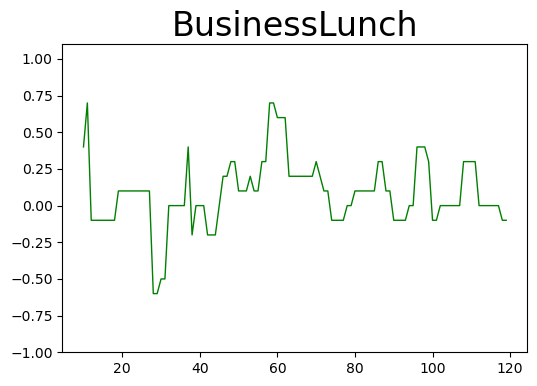

In [152]:
plt.rcParams['figure.figsize'] = (6, 4)
x = Business_Time_a.index
y1 = Business_Time_a['Update_p']
plt.ylim([-1, 1.1])
plt.plot(x,y1, color='green', linewidth = 1.0)
#plt.axhline(df['SceneP(recall)'].mean(), 0, 1, color='red', linestyle='solid', linewidth=0.5)
plt.title('BusinessLunch', fontsize =24)

### Runningman

In [288]:
#Runningman
Runningman = pd.read_excel(os.path.join(file,'BusRubrics.xlsx'), sheet_name = 'Runningman', usecols = [32,33,35,36])
Runningman.columns = {'SceneP(First)', 'SceneP(Second)','onset_time', 'onset_TR'}
Runningman = Runningman.fillna(0.0)
Runningman = Runningman[2::2] # 1부터 2행마다 
Runningman.reset_index(inplace=True)
Runningman['Update_p'] = Runningman['SceneP(Second)'] - Runningman['SceneP(First)'] 

Runningman = Runningman.astype({ 'Update_p' : 'float', 'SceneP(First)': 'float', 'SceneP(Second)': 'float', 'onset_TR' : 'float' })
Runningman['onset_TR'] = round(Runningman['onset_TR'])
Runningman

,index,SceneP(First),SceneP(Second),onset_time,onset_TR,Update_p
0,2,0.461538,0.615385,16,11.0,0.153846
1,4,0.923077,1.000000,36,24.0,0.076923
2,6,0.000000,0.846154,42,28.0,0.846154
3,8,0.076923,0.846154,45,30.0,0.769231
4,10,0.076923,0.692308,49,33.0,0.615385
5,12,0.000000,0.076923,61,41.0,0.076923
6,14,1.000000,0.923077,63,42.0,-0.076923
7,16,0.461538,0.153846,69,46.0,-0.307692
8,18,0.076923,0.384615,71,47.0,0.307692
9,20,0.000000,0.230769,74,49.0,0.230769


In [319]:
Runningman_Time = pd.DataFrame(index = range(0,125), columns = {'Update_p'})
for i in np.arange(Runningman.shape[0]-1):
    onset = round(Runningman['onset_TR'][i])-1
    offset = round(Runningman['onset_TR'][i+1])-1
    print('onset & offset' , onset, offset)
    Runningman_Time['Update_p'][onset:offset] = Runningman['Update_p'][i]
Runningman_Time[116:125] = -0.153846# 뒷 부분에 대한 ANNOTATION 이 달라져서 평균 값을 넣었다. 
Runningman_Time

onset & offset 10 23
onset & offset 23 27
onset & offset 27 29
onset & offset 29 32
onset & offset 32 40
onset & offset 40 41
onset & offset 41 45
onset & offset 45 46
onset & offset 46 48
onset & offset 48 50
onset & offset 50 50
onset & offset 50 52
onset & offset 52 56
onset & offset 56 58
onset & offset 58 59
onset & offset 59 63
onset & offset 63 66
onset & offset 66 68
onset & offset 68 70
onset & offset 70 74
onset & offset 74 75
onset & offset 75 76
onset & offset 76 78
onset & offset 78 79
onset & offset 79 80
onset & offset 80 82
onset & offset 82 86
onset & offset 86 87
onset & offset 87 89
onset & offset 89 92
onset & offset 92 96
onset & offset 96 97
onset & offset 97 99
onset & offset 99 102
onset & offset 102 103
onset & offset 103 105
onset & offset 105 106
onset & offset 106 111
onset & offset 111 114
onset & offset 114 116


,Update_p
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
120,-0.153846
121,-0.153846
122,-0.153846
123,-0.153846


In [320]:
Runningman_Time_a = Runningman_Time[10:125]
Runningman_Time_a.reset_index(drop = True)
print(pd.DataFrame(Z2[1]).shape, Runningman_Time_a.shape)

(115, 1) (115, 1)


Text(0.5, 1.0, 'Runningman')

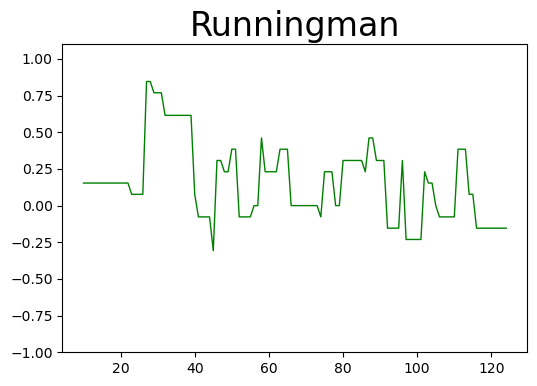

In [321]:
plt.rcParams['figure.figsize'] = (6, 4)
x = Runningman_Time_a.index
y1 = Runningman_Time_a['Update_p']
plt.ylim([-1, 1.1])
plt.plot(x,y1, color='green', linewidth = 1.0)
#plt.axhline(df['SceneP(recall)'].mean(), 0, 1, color='red', linestyle='solid', linewidth=0.5)
plt.title('Runningman', fontsize =24)

### Dance

In [355]:
#Load 
School = pd.read_excel(os.path.join(file,'BusRubrics.xlsx'), sheet_name = 'Dance', usecols = [28,29,31,32])
School = School.fillna(0.0)
School.columns = {'SceneP(First)', 'SceneP(Second)','onset_time', 'onset_TR'}
School = School[2::2] # 1부터 2행마다 
School.reset_index(inplace=True)
School['Update_p'] = School['SceneP(Second)'] - School['SceneP(First)'] 

School = School.astype({ 'Update_p' : 'float', 'SceneP(First)': 'float', 'SceneP(Second)': 'float', 'onset_TR' : 'float' })
School['onset_TR'] = round(School['onset_TR'])
School

,index,SceneP(First),SceneP(Second),onset_time,onset_TR,Update_p
0,2,0.090909,0.090909,15,10.0,0.000000
1,4,0.090909,0.090909,15,10.0,0.000000
2,6,1.000000,0.909091,16,11.0,-0.090909
3,8,0.000000,0.000000,20,13.0,0.000000
4,10,0.636364,0.545455,23,15.0,-0.090909
5,12,0.181818,0.636364,26,17.0,0.454545
6,14,0.090909,0.000000,30,20.0,-0.090909
7,16,0.636364,0.545455,31,21.0,-0.090909
8,18,0.909091,0.636364,33,22.0,-0.272727
9,20,0.363636,0.090909,34,23.0,-0.272727


In [356]:
School_Time = pd.DataFrame(index = range(0,125), columns = {'Update_p'})
for i in np.arange(School.shape[0]-1):
    onset = round(School['onset_TR'][i])-1
    offset = round(School['onset_TR'][i+1])-1
    print('onset & offset' , onset, offset)
    School_Time['Update_p'][onset:offset] = School['Update_p'][i]
School_Time[104:106] = -0.636364
School_Time[106:125] = School_Time['Update_p'].mean() # annotation 이 이전과 달라져서 그냥 mean 값을 넣어버렸다.
School_Time

onset & offset 9 9
onset & offset 9 10
onset & offset 10 12
onset & offset 12 14
onset & offset 14 16
onset & offset 16 19
onset & offset 19 20
onset & offset 20 21
onset & offset 21 22
onset & offset 22 23
onset & offset 23 26
onset & offset 26 29
onset & offset 29 32
onset & offset 32 34
onset & offset 34 38
onset & offset 38 40
onset & offset 40 42
onset & offset 42 42
onset & offset 42 44
onset & offset 44 48
onset & offset 48 50
onset & offset 50 52
onset & offset 52 54
onset & offset 54 55
onset & offset 55 57
onset & offset 57 58
onset & offset 58 60
onset & offset 60 61
onset & offset 61 65
onset & offset 65 66
onset & offset 66 76
onset & offset 76 105
onset & offset 105 80
onset & offset 80 81
onset & offset 81 82
onset & offset 82 84
onset & offset 84 85
onset & offset 85 86
onset & offset 86 90
onset & offset 90 94
onset & offset 94 99
onset & offset 99 102
onset & offset 102 104


,Update_p
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
120,0.098407
121,0.098407
122,0.098407
123,0.098407


In [357]:
School_Time_a = School_Time[10:125]
School_Time_a.reset_index(drop = True)
print(pd.DataFrame(Z4[1]).shape, School_Time_a.shape)
School_Time_a

(115, 1) (115, 1)


,Update_p
10,-0.090909
11,-0.090909
12,0.0
13,0.0
14,-0.090909
...,...
120,0.098407
121,0.098407
122,0.098407
123,0.098407


Text(0.5, 1.0, 'S05 WayToSchool')

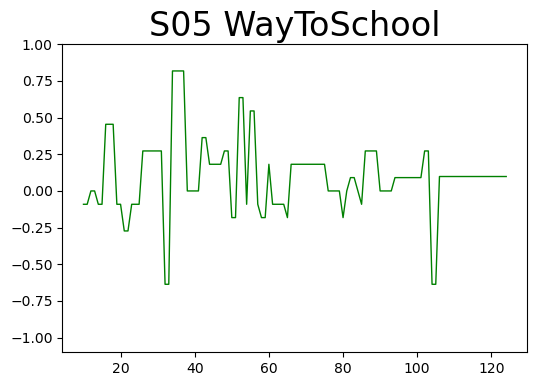

In [359]:
plt.rcParams['figure.figsize'] = (6, 4)
x = School_Time_a.index
y1 = School_Time_a['Update_p']
plt.ylim([-1.1,1])
plt.plot(x,y1, color='green', linewidth = 1.0)
#plt.axhline(df['SceneP(recall)'].mean(), 0, 1, color='red', linestyle='solid', linewidth=0.5)
plt.title('S05 WayToSchool', fontsize =24)

### Avata

In [355]:
#Load 
School = pd.read_excel(os.path.join(file,'BusRubrics.xlsx'), sheet_name = 'Dance', usecols = [28,29,31,32])
School = School.fillna(0.0)
School.columns = {'SceneP(First)', 'SceneP(Second)','onset_time', 'onset_TR'}
School = School[2::2] # 1부터 2행마다 
School.reset_index(inplace=True)
School['Update_p'] = School['SceneP(Second)'] - School['SceneP(First)'] 

School = School.astype({ 'Update_p' : 'float', 'SceneP(First)': 'float', 'SceneP(Second)': 'float', 'onset_TR' : 'float' })
School['onset_TR'] = round(School['onset_TR'])
School

,index,SceneP(First),SceneP(Second),onset_time,onset_TR,Update_p
0,2,0.090909,0.090909,15,10.0,0.000000
1,4,0.090909,0.090909,15,10.0,0.000000
2,6,1.000000,0.909091,16,11.0,-0.090909
3,8,0.000000,0.000000,20,13.0,0.000000
4,10,0.636364,0.545455,23,15.0,-0.090909
5,12,0.181818,0.636364,26,17.0,0.454545
6,14,0.090909,0.000000,30,20.0,-0.090909
7,16,0.636364,0.545455,31,21.0,-0.090909
8,18,0.909091,0.636364,33,22.0,-0.272727
9,20,0.363636,0.090909,34,23.0,-0.272727


In [356]:
School_Time = pd.DataFrame(index = range(0,125), columns = {'Update_p'})
for i in np.arange(School.shape[0]-1):
    onset = round(School['onset_TR'][i])-1
    offset = round(School['onset_TR'][i+1])-1
    print('onset & offset' , onset, offset)
    School_Time['Update_p'][onset:offset] = School['Update_p'][i]
School_Time[104:106] = -0.636364
School_Time[106:125] = School_Time['Update_p'].mean() # annotation 이 이전과 달라져서 그냥 mean 값을 넣어버렸다.
School_Time

onset & offset 9 9
onset & offset 9 10
onset & offset 10 12
onset & offset 12 14
onset & offset 14 16
onset & offset 16 19
onset & offset 19 20
onset & offset 20 21
onset & offset 21 22
onset & offset 22 23
onset & offset 23 26
onset & offset 26 29
onset & offset 29 32
onset & offset 32 34
onset & offset 34 38
onset & offset 38 40
onset & offset 40 42
onset & offset 42 42
onset & offset 42 44
onset & offset 44 48
onset & offset 48 50
onset & offset 50 52
onset & offset 52 54
onset & offset 54 55
onset & offset 55 57
onset & offset 57 58
onset & offset 58 60
onset & offset 60 61
onset & offset 61 65
onset & offset 65 66
onset & offset 66 76
onset & offset 76 105
onset & offset 105 80
onset & offset 80 81
onset & offset 81 82
onset & offset 82 84
onset & offset 84 85
onset & offset 85 86
onset & offset 86 90
onset & offset 90 94
onset & offset 94 99
onset & offset 99 102
onset & offset 102 104


,Update_p
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
120,0.098407
121,0.098407
122,0.098407
123,0.098407


In [357]:
School_Time_a = School_Time[10:125]
School_Time_a.reset_index(drop = True)
print(pd.DataFrame(Z4[1]).shape, School_Time_a.shape)
School_Time_a

(115, 1) (115, 1)


,Update_p
10,-0.090909
11,-0.090909
12,0.0
13,0.0
14,-0.090909
...,...
120,0.098407
121,0.098407
122,0.098407
123,0.098407


Text(0.5, 1.0, 'S05 WayToSchool')

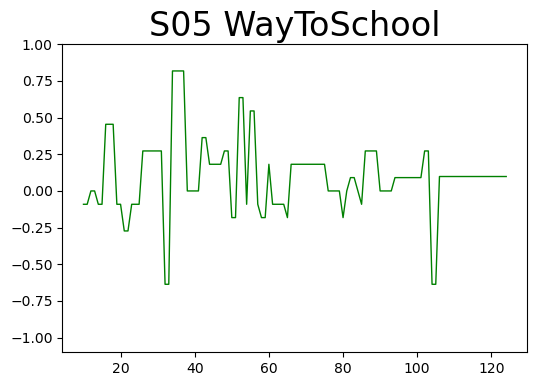

In [359]:
plt.rcParams['figure.figsize'] = (6, 4)
x = School_Time_a.index
y1 = School_Time_a['Update_p']
plt.ylim([-1.1,1])
plt.plot(x,y1, color='green', linewidth = 1.0)
#plt.axhline(df['SceneP(recall)'].mean(), 0, 1, color='red', linestyle='solid', linewidth=0.5)
plt.title('S05 WayToSchool', fontsize =24)

# Compare spatial ISC and Dynamic Counting
- (1) Dynamic Counting 은 averaged updated probability 활용 (그래서 값이 하나)
- (2) 개별 참가자마다 인코딩 순서 Load 
- (3) 개별 참가자마다 각 이야기에 대한 sISC 과 Update Probability 정렬 

## 전체 참가자들에 대한 Comparison 

In [708]:
Zsocres = {}
mean = {}
for sub in subjects:
    Z = {}
    roi_isc = {}
    for s in np.arange(1,6): 
        for r in np.arange(0,50):
            roi = all_roi_isc[sub][s][r]
            roi = np.arctanh(roi) 
            roi_isc[r] = roi
        Z[s] = roi_isc
    Zsocres[sub] = Z

In [748]:
Zsocres[sub][story][roi] = timelines 

{0: array([ 3.51802448e-02,  1.13925575e-01,  3.12975669e-01,  2.05525145e-05,
         4.93929407e-02,  2.33113529e-02, -1.40623924e-01, -9.22391730e-02,
        -1.98078006e-01,  1.86449209e-02, -2.93634407e-01, -1.04079645e-01,
        -2.68620885e-01, -3.58742341e-01,  1.26155355e-01,  5.37227130e-02,
        -2.86238324e-01,  7.51572255e-02, -1.60790276e-01, -2.02379211e-01,
         2.73426181e-01,  1.03021103e-01,  5.72064201e-02,  6.32651703e-02,
         1.91812282e-01,  2.13576463e-01,  2.12301846e-01,  1.30184172e-01,
         8.11781204e-02,  2.06266814e-01, -2.67777639e-02, -2.53945540e-01,
        -4.90232130e-02,  1.44211653e-02,  7.38783419e-02,  6.06213385e-02,
        -2.48965934e-01,  9.90571838e-02,  2.98199152e-01,  3.65409800e-02,
        -2.38805677e-01, -1.48825569e-01, -4.10669274e-01,  2.28280952e-02,
         1.49816608e-01, -3.13491892e-01,  7.01006105e-02,  1.49326349e-01,
         3.38880649e-01,  1.29991803e-01,  7.94302438e-02, -9.29654181e-04,
        -

In [766]:
from scipy import stats

#behav = [ Runningman_Time_a, Business_Time_a, School_Time_a, Blind_Time_a, Neighbor_Time_a, King_Time_a, TwoBoys_Time_a, YoungSignal_Time_a ]
behav = [ Runningman_Time_a, Business_Time_a, School_Time_a] #, Blind_Time_a, Neighbor_Time_a]
storyline = {'05': [2, 5, 4], '06': [2, 3, 4]}
subjects = ['05', '06']

total_r = {}
for sub in subjects:    
    sub_r = {}
    for s in np.arange(0,3) :
        sub_behav = behav[s].reset_index(drop = True)
        sub_behav = sub_behav['Update_p']
        sub_behav = sub_behav.astype({ 'Update_p' : 'float' })        
        sub_x = {}
        story_r = {} 
        for r in np.arange(0,50):
            Z = Zsocres[sub][storyline[sub][s]][r]
            sub_story_r = []
            Z = pd.DataFrame(np.array(Z))
            data = pd.concat([sub_behav,Z], axis = 1)
            data.columns = {'Update_p','Spatial_ISC'}
            story_r[r] = data.corr()['Spatial_ISC']['Update_p']
        sub_r[s] = story_r
    total_r[sub] = sub_r

In [767]:
total_r['05']

{0: {0: 0.17413226602697862,
  1: 0.22553398077869155,
  2: 0.17134010862082424,
  3: 0.16353886916401647,
  4: 0.1607055970812019,
  5: 0.0990423212691523,
  6: 0.10823567555009862,
  7: 0.1265556454412639,
  8: 0.044320421405384273,
  9: 0.04246825459815125,
  10: 0.22991152390097971,
  11: 0.3196691487402918,
  12: 0.14171740486184609,
  13: 0.18519347735154076,
  14: 0.13833451908562278,
  15: 0.0872056299731539,
  16: 0.0856039547403319,
  17: 0.07530955166046606,
  18: -0.08471070334920287,
  19: 0.23059803449734134,
  20: 0.40781115965931153,
  21: 0.13981586726366413,
  22: 0.14970488613191593,
  23: 0.05149617157076224,
  24: 0.14282814832173057,
  25: 0.21751954423715741,
  26: 0.04437805980732748,
  27: 0.02086141777208327,
  28: 0.16829080845485903,
  29: 0.04613404124314092,
  30: 0.061639948206235085,
  31: 0.06577714115775965,
  32: 0.06987035746697039,
  33: 0.15255587554188252,
  34: 0.11083158797444485,
  35: 0.06496345802374671,
  36: 0.2432837271462274,
  37: 0.1033

In [782]:
HPC_r_05 = []
HPC_r_06 = []
for i in np.arange(0,3):
    HPC_r_05 = np.append(HPC_r_05, total_r['05'][i][28])
    HPC_r_06 = np.append(HPC_r_06, total_r['06'][i][28])
    


vmPFC_r_05 = []
vmPFC_r_06 = []
for i in np.arange(0,3):
    vmPFC_r_05 = np.append(vmPFC_r_05, total_r['05'][i][32])
    vmPFC_r_06 = np.append(vmPFC_r_06, total_r['06'][i][32])
PCC_r_05 = []
PCC_r_06 = []
for i in np.arange(0,3):
    PCC_r_05 = np.append(PCC_r_05, total_r['05'][i][6])
    PCC_r_06 = np.append(PCC_r_06, total_r['06'][i][6])
TPJ_r_05 = []
TPJ_r_06 = []
for i in np.arange(0,3):
    TPJ_r_05 = np.append(TPJ_r_05, total_r['05'][i][5])
    TPJ_r_06 = np.append(TPJ_r_06, total_r['06'][i][5])


print(" Correlation between Updating Probability and spatial ISC")
print('                                                                ')

print('HPC of S05: ', 'Runningman %.3f'% (HPC_r_05[0]), ' Business %.3f'% (HPC_r_05[1]), ' School%.3f'% (HPC_r_05[2]), ' mean %.3f'% (HPC_r_05.mean()))
print('HPC of S06: ', 'Runningman %.3f'% (HPC_r_06[0]), ' Business %.3f'% (HPC_r_06[1]), ' School%.3f'% (HPC_r_06[2]), ' mean %.3f'% (HPC_r_06.mean()))
print('                                                                ')
print('vmPFC of S05: ', 'Runningman %.3f'% (vmPFC_r_05[0]), ' Business %.3f'% (vmPFC_r_05[1]), ' School%.3f'% (vmPFC_r_05[2]), ' mean %.3f'% (vmPFC_r_05.mean()))
print('vmPFC of S06: ','Runningman %.3f'% (vmPFC_r_06[0]), ' Business %.3f'% (vmPFC_r_06[1]), ' School%.3f'% (vmPFC_r_06[2]), ' mean %.3f'% (vmPFC_r_06.mean()))    
print('                                                                ')
print('PCC of S05: ', 'Runningman %.3f'% (PCC_r_05[0]), ' Business %.3f'% (PCC_r_05[1]), ' School%.3f'% (PCC_r_05[2]), ' mean %.3f'% (PCC_r_05.mean()))
print('PCC of S06: ','Runningman %.3f'% (PCC_r_06[0]), ' Business %.3f'% (PCC_r_06[1]), ' School%.3f'% (PCC_r_06[2]), ' mean %.3f'% (PCC_r_06.mean()))    
print('                                                                ')
print('TPJ of S05: ', 'Runningman %.3f'% (TPJ_r_05[0]), ' Business %.3f'% (TPJ_r_05[1]), ' School%.3f'% (TPJ_r_05[2]), ' mean %.3f'% (TPJ_r_05.mean()))
print('TPJ of S06: ','Runningman %.3f'% (TPJ_r_06[0]), ' Business %.3f'% (TPJ_r_06[1]), ' School%.3f'% (TPJ_r_06[2]), ' mean %.3f'% (TPJ_r_06.mean()))


#r['05'][0] - r['06'][0]

 Correlation between Updating Probability and spatial ISC
                                                                
HPC of S05:  Runningman 0.168  Business 0.187  School0.154  mean 0.170
HPC of S06:  Runningman -0.003  Business -0.074  School-0.065  mean -0.047
                                                                
vmPFC of S05:  Runningman 0.070  Business 0.081  School-0.087  mean 0.021
vmPFC of S06:  Runningman 0.042  Business 0.081  School-0.017  mean 0.036
                                                                
PCC of S05:  Runningman 0.108  Business 0.128  School0.029  mean 0.088
PCC of S06:  Runningman 0.032  Business 0.241  School0.000  mean 0.091
                                                                
TPJ of S05:  Runningman 0.099  Business 0.018  School-0.076  mean 0.013
TPJ of S06:  Runningman 0.119  Business 0.138  School0.090  mean 0.116


Text(0.5, 1.0, 'sub-05 mean r ')

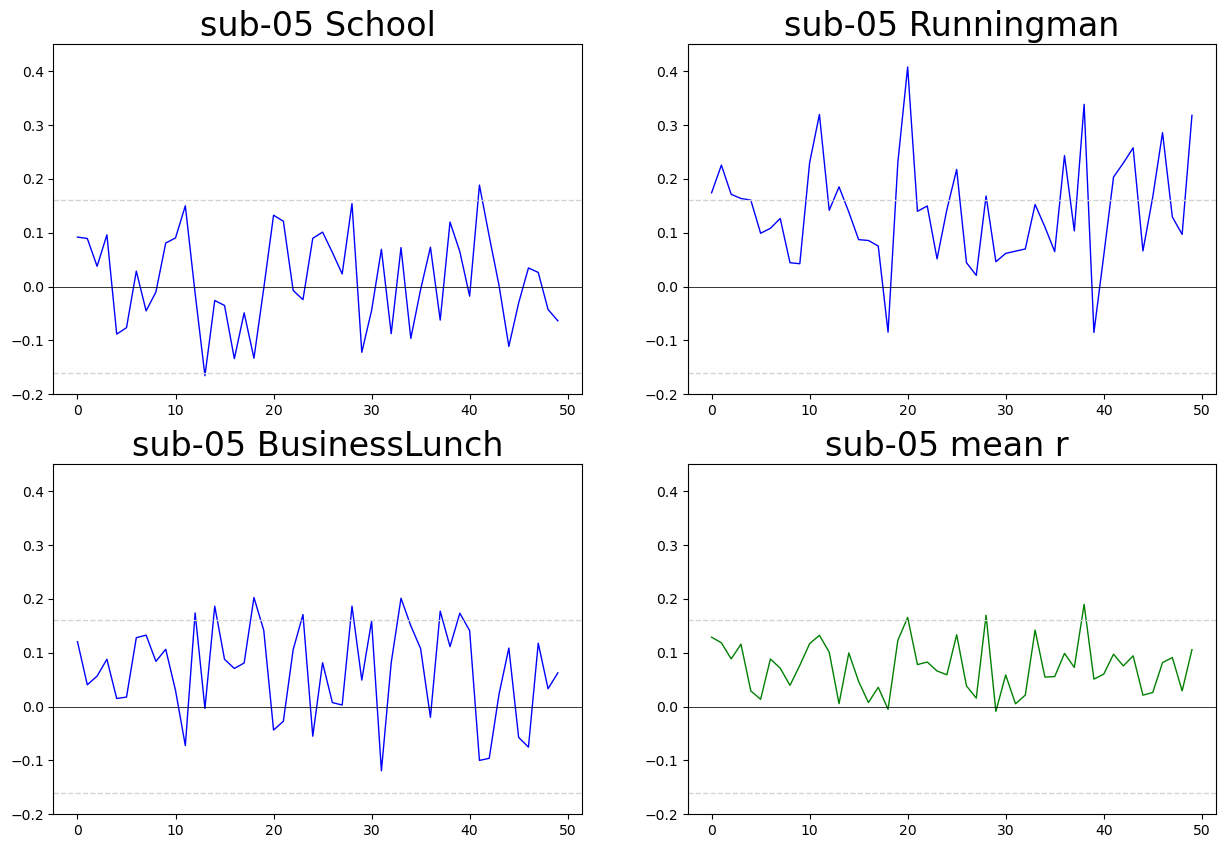

In [413]:
# plot 3 stories of Sub-05

from scipy.interpolate import make_interp_spline

plt.rcParams['figure.figsize'] = (15, 10)

plt.subplot(2,2,1)
plt.rcParams['figure.figsize'] = (6, 5)
plt.plot(r_School, color='blue', linewidth = 1.0)
plt.ylim([-0.2, 0.45])
plt.axhline(0.16, 0, 50, color='lightgray', linestyle='--', linewidth=1)
plt.axhline(0, 0, 50, color='black', linestyle='solid', linewidth=0.55)
plt.axhline(-0.16, 0, 50, color='lightgray', linestyle='--', linewidth=1)
#plt.axhline(df['SceneP(recall)'].mean(), 0, 1, color='red', linestyle='solid', linewidth=0.5)
plt.title('sub-05 School', fontsize =24)


plt.subplot(2,2,2)    
plt.rcParams['figure.figsize'] = (6, 5)
plt.plot(r_Runningman, color='blue', linewidth = 1.0)
plt.ylim([-0.2, 0.45])
plt.axhline(0.16, 0, 50, color='lightgray', linestyle='--', linewidth=1)
plt.axhline(0, 0, 50, color='black', linestyle='solid', linewidth=0.55)
plt.axhline(-0.16, 0, 50, color='lightgray', linestyle='--', linewidth=1)
#plt.axhline(df['SceneP(recall)'].mean(), 0, 1, color='red', linestyle='solid', linewidth=0.5)
plt.title('sub-05 Runningman', fontsize =24)
    

plt.subplot(2,2,3) 
plt.rcParams['figure.figsize'] = (6, 5)
plt.plot(r_Business, color='blue', linewidth = 1.0)
plt.ylim([-0.2, 0.45])
plt.axhline(0.16, 0, 50, color='lightgray', linestyle='--', linewidth=1)
plt.axhline(0, 0, 50, color='black', linestyle='solid', linewidth=0.55)
plt.axhline(-0.16, 0, 50, color='lightgray', linestyle='--', linewidth=1)
#plt.axhline(df['SceneP(recall)'].mean(), 0, 1, color='red', linestyle='solid', linewidth=0.5)
plt.title('sub-05 BusinessLunch', fontsize =24)
    
    

plt.subplot(2,2,4) 
plt.rcParams['figure.figsize'] = (6, 5)
plt.plot(mean_r, color='green', linewidth = 1.0)
plt.ylim([-0.2, 0.45])
plt.axhline(0.16, 0, 50, color='lightgray', linestyle='--', linewidth=1)
plt.axhline(0, 0, 50, color='black', linestyle='solid', linewidth=0.55)
plt.axhline(-0.16, 0, 50, color='lightgray', linestyle='--', linewidth=1)
#plt.axhline(df['SceneP(recall)'].mean(), 0, 1, color='red', linestyle='solid', linewidth=0.5)
plt.title('sub-05 mean r ', fontsize =24)
    

## Practice (1) sub-05

### S05 - BusinessLunch

- (1) 이야기 Event / Scene을 실제 영상 timecourse에 매칭시키기 !! 
- (2) 개별 이야기에 대한 상관 값 계산하기

In [305]:
from scipy import stats

x = Business_Time_a.reset_index(drop = True)
x = x['Update_p']
x = x.astype({ 'Update_p' : 'float' })

r_Business = []
for i in np.arange(Z5.shape[1]):
    y = pd.DataFrame(np.array(Z5[i]))
    data = pd.concat([x,y], axis = 1)
    data.columns = {'Update_p','Spatial_ISC'}
    r_Business= np.append( r_Business, data.corr()['Spatial_ISC']['Update_p'])

Text(0.5, 1.0, 'S05 BusinessLunch')

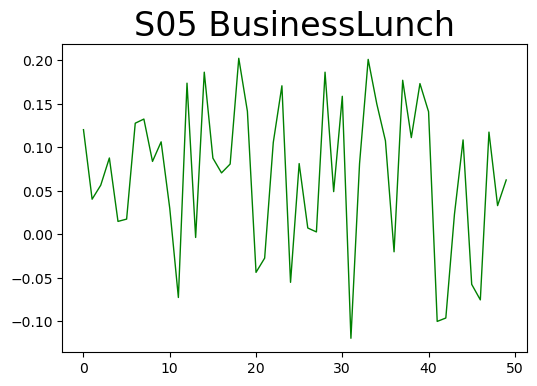

In [306]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(r_Business, color='green', linewidth = 1.0)
#plt.axhline(df['SceneP(recall)'].mean(), 0, 1, color='red', linestyle='solid', linewidth=0.5)
plt.title('S05 BusinessLunch', fontsize =24)

In [309]:
r_Business.shape

df= pd.DataFrame(r_Business)
df[df[0] >= 0.17]  # Hippocampus가 나왔음... dld... .
# roi == 19 & 34 가 0.2 넘음 
#df
#df[df[0] <= - 0.1] 

,0
12,0.173935
14,0.186557
18,0.202545
23,0.170923
28,0.186563
33,0.201257
37,0.177263
39,0.173442


### S05 - Runningmam

In [322]:
from scipy import stats

x = Runningman_Time_a.reset_index(drop = True)
x = x['Update_p']
x = x.astype({ 'Update_p' : 'float' })

r_Runningman = []
r
for i in np.arange(Z2.shape[1]):
    y = pd.DataFrame(np.array(Z5[i]))
    data = pd.concat([x,y], axis = 1)
    data.columns = {'Update_p','Spatial_ISC'}
    r_Runningman= np.append( r_Runningman, data.corr()['Spatial_ISC']['Update_p'])

Text(0.5, 1.0, 'S05 Runningman')

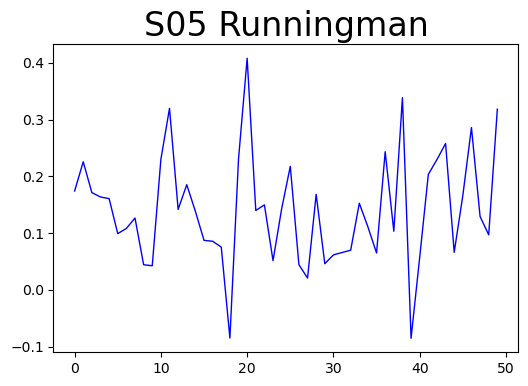

In [323]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(r_Runningman, color='blue', linewidth = 1.0)
#plt.axhline(df['SceneP(recall)'].mean(), 0, 1, color='red', linestyle='solid', linewidth=0.5)
plt.title('S05 Runningman', fontsize =24)

In [327]:
r_Runningman.shape

df= pd.DataFrame(r_Runningman)
df[df[0] >= 0.15]  # Hippocampus가 나왔음... dld... .
# roi == 19 & 34 가 0.2 넘음 


,0
0,0.174132
1,0.225534
2,0.171340
3,0.163539
4,0.160706
10,0.229912
11,0.319669
13,0.185193
19,0.230598
20,0.407811


### WayToSchool

In [360]:
from scipy import stats

x = School_Time_a.reset_index(drop = True)
x = x['Update_p']
x = x.astype({ 'Update_p' : 'float' })

r_School = []
for i in np.arange(Z2.shape[1]):
    y = pd.DataFrame(np.array(Z5[i]))
    data = pd.concat([x,y], axis = 1)
    data.columns = {'Update_p','Spatial_ISC'}
    r_School= np.append( r_School, data.corr()['Spatial_ISC']['Update_p'])

Text(0.5, 1.0, 'S05 School')

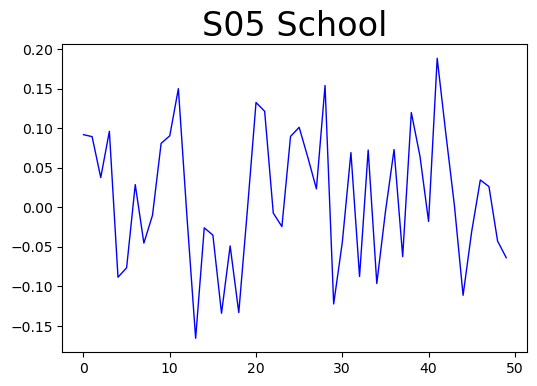

In [361]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(r_School, color='blue', linewidth = 1.0)
#plt.axhline(df['SceneP(recall)'].mean(), 0, 1, color='red', linestyle='solid', linewidth=0.5)
plt.title('S05 School', fontsize =24)

In [362]:
r_School.shape

df= pd.DataFrame(r_School)
df[df[0] >= 0.15]  # Hippocampus가 나왔음... dld... .
# roi == 19 & 34 가 0.2 넘음 

,0
11,0.150021
28,0.154060
41,0.188426


### Mean R for sub-05

In [364]:
mean_r = (r_School + r_Business + r_Runningman)/ 3

In [366]:
mean_r.shape

df= pd.DataFrame(mean_r)
df[df[0] >= 0.15]  # Hippocampus가 나왔음... dld... .

,0
20,0.165590
28,0.169638
38,0.189888


Text(0.5, 1.0, 'sISC of HPC and Update Scorees of Runningman')

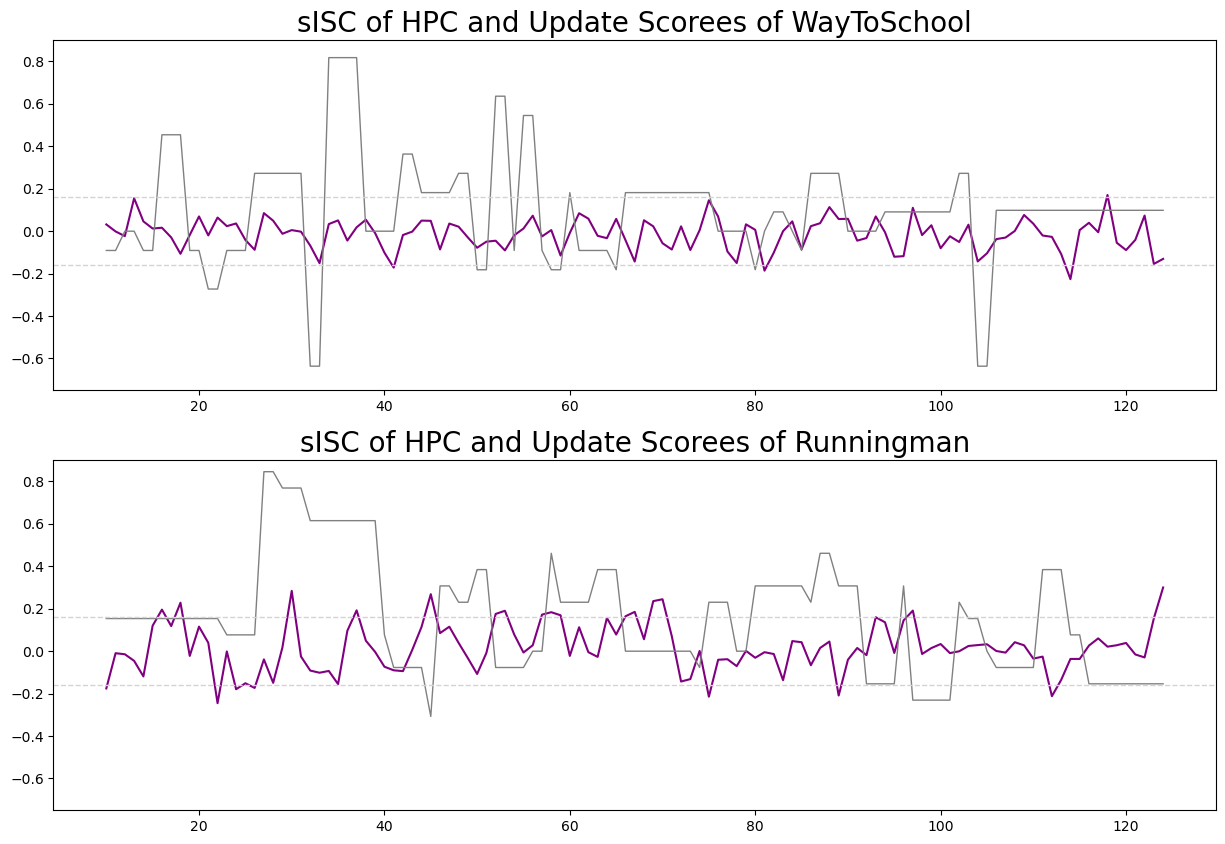

In [404]:
from scipy.interpolate import make_interp_spline

plt.tight_layout()
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplot(2,1,1)
x = School_Time_a.index
y1 = School_Time_a['Update_p']
y2 = Z4[28]
plt.ylim([-0.75, 0.9])
plt.plot(x,y2, color='purple', linewidth = 1.5)
plt.plot(x,y1, color='gray', linewidth = 1)
plt.axhline(0.16, 0, 110, color='lightgray', linestyle='--', linewidth=1)
plt.axhline(-0.16, 0, 110, color='lightgray', linestyle='--', linewidth=1)
#plt.axhline(0, 0, 110, color='black', linestyle='solid', linewidth=0.5)
plt.title('sISC of HPC and Update Scorees of WayToSchool', fontsize =20)    



plt.subplot(2,1,2)
x = Runningman_Time_a.index
y1 = Runningman_Time_a['Update_p']
y2 = Z2[28]
plt.ylim([-0.75, 0.9])
plt.plot(x,y2, color='purple', linewidth = 1.5)
plt.plot(x,y1, color='gray', linewidth = 1)
plt.axhline(0.16, 0, 110, color='lightgray', linestyle='--', linewidth=1)
plt.axhline(-0.16, 0, 110, color='lightgray', linestyle='--', linewidth=1)
#plt.axhline(0, 0, 110, color='black', linestyle='solid', linewidth=0.5)
plt.title('sISC of HPC and Update Scorees of Runningman', fontsize =20)    

### ROIS 

#### Recap : Hippocampus가 계속 나옴.. mean HPC (r) = 0.17 